<a id='0.1'></a>
## 0.1 load required packages

# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>
> 1. [Extract region sequences](#1)

<a id='0.1'></a>
## 0.1 load required packages

In [1]:
%run "C:\\Users\\shiwei\\Documents\\ImageAnalysis3\\required_files\\Startup_py3.py"
sys.path.append(r"C:\\Users\\shiwei\\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

2022-01-19 18:16:15,577 [INFO] WRITING LOG OUTPUT TO C:\Users\shiwei\.cellpose\run.log
19764


<a id='1'></a>
# 1 Extract region sequences

In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers'

In [3]:
resolution = 0
flanking = 5000 #


# generate folders for sub-pool
library_folder = os.path.join(pool_folder, 
                              f'mop_SE_1000')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\reports


## 1.1 Convert SE peak dataframe into bed-like format

In [30]:
import pandas as pd

sel_SE_df = pd.read_excel(library_folder+os.sep+'merged_selected_SE_all_cell_types.xlsx', index_col=None)

In [33]:
print(len(sel_SE_df))
sel_SE_df.head()

# merged_initial_index shows the initial index before merging, which can be used to locate detailed info (e.g., loci number)
# using the combined_cell_type_SE.xlsx

991


,CHROM,merged_START,merged_STOP,merged_CELL_TYPE,merged_initial_index,score,ave_score,merged_SIZE
0,chr1,9610471,9646458,['L6_CT'],[10392],[1.],1.0,35987
1,chr1,9759317,9835402,['L2_3_IT'],[2107],[1.],1.0,76085
2,chr1,20898605,20943251,['Astro'],[194],[1.],1.0,44646
3,chr1,21485446,21554433,['L2_3_IT'],[2210],[1.],1.0,68987
4,chr1,21684557,21783163,['Sncg'],[17985],[1.],1.0,98606


In [36]:
# split chrX from other chromosomes to sort chromosomes (not required for probe design later)
sel_SE_df_chrX = sel_SE_df[984:]
sel_SE_df_chrN = sel_SE_df[:984]


# sort other chromosomes
sel_SE_df_chrN['sort_CHROM'] = [int(i.split('chr')[-1]) for i in sel_SE_df_chrN['CHROM']]
# set chrX as chr20
sel_SE_df_chrX['sort_CHROM'] = 20

# sort
sel_SE_df_sort_chrN = sel_SE_df_chrN.sort_values(by =['sort_CHROM', 'merged_START'])
sel_SE_df_sort_chrX = sel_SE_df_chrX.sort_values(by =['sort_CHROM', 'merged_START'])


<ipython-input-36-6bd7711621a2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_SE_df_chrN['sort_CHROM'] = [int(i.split('chr')[-1]) for i in sel_SE_df_chrN['CHROM']]
<ipython-input-36-6bd7711621a2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_SE_df_chrX['sort_CHROM'] = 20


In [37]:
# combine chrX and other chromosome after sorting
sel_SE_df_sort_all = pd.concat([sel_SE_df_sort_chrN, sel_SE_df_sort_chrX])
# reset index
sel_SE_df_new = sel_SE_df_sort_all.reset_index()

# add new region name;
sel_SE_df_new['region_name'] = sel_SE_df_new.index +1

# index col shows the original index(region) name which can be used to locate the SE before merging 
# original SE de: merged_selected_SE_all_cell_types.xlsx or the sel_SE_df
# merged_selected_SE_all_cell_types.xlsx contains the top 991 SE after filtering using the merged_SE_all_cell_types.xlsx
# see merging and filtering details from below: 
# http://localhost:8889/notebooks/Documents/Chromatin_Analysis_Scripts/Library_design/CTP13-mop-merged-1000-SE/super_enhancer_MOP_combined_all_cell_types.ipynb

sel_SE_df_new[:100]

,index,CHROM,merged_START,merged_STOP,merged_CELL_TYPE,merged_initial_index,score,ave_score,merged_SIZE,sort_CHROM,region_name
0,0,chr1,9610471,9646458,['L6_CT'],[10392],[1.],1.00000,35987,1,1
1,1,chr1,9759317,9835402,['L2_3_IT'],[2107],[1.],1.00000,76085,1,2
2,2,chr1,20898605,20943251,['Astro'],[194],[1.],1.00000,44646,1,3
3,3,chr1,21485446,21554433,['L2_3_IT'],[2210],[1.],1.00000,68987,1,4
4,4,chr1,21684557,21783163,['Sncg'],[17985],[1.],1.00000,98606,1,5
...,...,...,...,...,...,...,...,...,...,...,...
95,534,chr2,49908807,49960037,['Sst'],[19796],[1.],1.00000,51230,2,96
96,535,chr2,58015861,58055893,['Oligo'],[15779],[1.],1.00000,40032,2,97
97,536,chr2,59644429,59675853,['Oligo'],[16120],[1.],1.00000,31424,2,98
98,537,chr2,62477453,62533544,"['L6_CT', 'L5_IT', 'L4_5_IT', 'L2_3_IT', 'L6_IT']","[10667, 6494, 3413, 2156, 12347]",[0.88267 0.99257 0.82405 0.78742 0.78774],0.85489,56091,2,99


In [38]:
# Use relevant columns to make a new dataframe for bed
sel_SE_df_for_bed =sel_SE_df_new[['CHROM','merged_START','merged_STOP','region_name']]
sel_SE_df_for_bed['merged_START_str']=[str(i) for i in sel_SE_df_for_bed['merged_START']]
sel_SE_df_for_bed['merged_STOP_str']=[str(i) for i in sel_SE_df_for_bed['merged_STOP']]
sel_SE_df_for_bed['region_name_str']=[str(i) for i in sel_SE_df_for_bed['region_name']]

sel_SE_df_for_bed = sel_SE_df_for_bed[['CHROM','merged_START_str','merged_STOP_str','region_name_str']]
sel_SE_df_for_bed.head()

<ipython-input-38-10a9c88213e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_SE_df_for_bed['merged_START_str']=[str(i) for i in sel_SE_df_for_bed['merged_START']]
<ipython-input-38-10a9c88213e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_SE_df_for_bed['merged_STOP_str']=[str(i) for i in sel_SE_df_for_bed['merged_STOP']]
<ipython-input-38-10a9c88213e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,CHROM,merged_START_str,merged_STOP_str,region_name_str
0,chr1,9610471,9646458,1
1,chr1,9759317,9835402,2
2,chr1,20898605,20943251,3
3,chr1,21485446,21554433,4
4,chr1,21684557,21783163,5


In [ ]:
#generate a 'bed' like file from the processed dataframe above

region_file = os.path.join(library_folder, 'Seleted_merged_super_enhancer_list.bed')
import csv


with open(region_file, 'w') as _reg_file: # bed-file

    #tsv_writer = csv.writer(_reg_file, delimiter='\\t')  
    #new_line_writer = csv.writer(_reg_file, delimiter='\\n')
    
    # get all columns
    df_columns = list(sel_SE_df_for_bed.columns)
    
    # for each SE, then for each column
    for _peak in sel_SE_df_for_bed.iloc():
        for  _col in df_columns:
            _reg_file.write(str(_peak[_col])) # append info
            _reg_file.write('\\t') # tab each column
        
        # newline for each SE
        _reg_file.write('\\n')
        


## 1.2 Extract seqeuence from the bed file

In [20]:


reload(library_tools.sequences)
region_file = os.path.join(library_folder, 'Seleted_merged_super_enhancer_list.bed')
region_dict = library_tools.sequences.read_region_file(region_file)
# add strand information
for _i in range(len(region_dict)):
    region_dict[_i]['Strand'] = '+'
# extract and save the corresponding sequence as individual fasta    
records = library_tools.sequences.extract_sequence(region_dict, genome_folder, 
                                                   resolution=resolution,
                                                   flanking=flanking,
                                                   save_folder=sequence_folder)

Input region file is: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\Super_enhancer_list_mTEC.bed
- 966 regions loaded from file: Super_enhancer_list_mTEC.bed
-- searching among 23 references
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.1.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.14.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.16.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\L

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.7.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.c

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.14.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.1.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.17.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.18.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dn

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.15.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.3.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.7.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.9.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.9.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.15.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.9.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.c

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.3.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.1.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.19.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.17.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.10.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.14.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.13.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.d

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.7.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.7.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.19.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.c

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.3.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.15.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.12.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.18.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.10.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.14.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.3.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.15.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dn

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.1.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.1.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.10.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.12.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.10.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.18.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.9.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.16.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.7.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.10.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.2.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.3.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.5.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.6.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.9.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.ch

-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.9.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.1.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.4.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.11.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.14.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.chromosome.8.fa.
-- a match found in file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Genome\Mus_musculus.GRCm38.dna.

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\15-chr5-17565-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\19-chr8-15670-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\16-chr7-17933-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\13-chr11-636-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\14-chr11-5021-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\11-chr16-472-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\18-chr15-14399-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Librari

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\6-chr16-32-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\9-chr18-7526-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr1-198-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\8-chr1-23055-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\9-chr5-17543-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\10-chr2-16995-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr14-9697-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr11-5024-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr9-4391-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr9-18171-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr9-2500-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr6-21733-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\8-chr11-1765-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr16-19253-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr4-19941-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr10-1529-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr11-1855-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr12-14160-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\6-chr2-13153-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\7-chr16-2829-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\6-chr13-14190-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\C

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr18-9829-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr8-20289-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr2-431-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr6-2314-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr11-20455-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr4-9275-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr11-22310-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\6-chr11-24971-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr15-7473-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr11-4722-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr4-158-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr9-15748-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr9-12484-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\6-chr5-8521-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr6-9365-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr11-18702-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr1-14711-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr9-3289-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr15-8115-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr1-19646-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr2-17071-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr11-10471-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr9-20331-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr10-12541-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr10-6756-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr13-8871-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr8-6677-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr7-4935-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr16-16503-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\5-chr17-9784-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr5-15322-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr17-14482-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr8-20284-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr16-22743-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\2-chr7-67-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr16-19309-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr11-14052-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr4-17451-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr13-2815-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr11-18662-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\2-chr11-7990-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr4-21432-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr14-7426-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr8-18052-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\2-chr16-19238-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr5-15261-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr12-5851-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\3-chr5-15326-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\SuperEnhancers\sequences\4-chr3-12045-lociStitched_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

In [45]:
# calculate num of regions in each chro
chr_2_region_num = {}
for _reg_info in region_dict:
    _chr_name = _reg_info['Chr']
    if 'chr' in _chr_name:
        _chr = _chr_name.split('chr')[1]
    else:
        _chr = _chr_name
    if _chr not in chr_2_region_num:
        chr_2_region_num[_chr] = 0
    chr_2_region_num[_chr] += 1
# save
pickle.dump(chr_2_region_num, open(os.path.join(library_folder,'chr_2_region_num.pkl'), 'wb'))

In [47]:
region_dict

[{'Chr': 'chr1',
  'Start': '189749530',
  'End': '189847686',
  'Name': '20-chr1-6997-lociStitched',
  'Gene': '20-chr1-6997-lociStitched',
  'Region': '1:189749530-189847686',
  'Strand': '+'},
 {'Chr': 'chr14',
  'Start': '74848823',
  'End': '74943405',
  'Name': '19-chr14-16350-lociStitched',
  'Gene': '19-chr14-16350-lociStitched',
  'Region': '14:74848823-74943405',
  'Strand': '+'},
 {'Chr': 'chr6',
  'Start': '134116442',
  'End': '134191730',
  'Name': '17-chr6-21729-lociStitched',
  'Gene': '17-chr6-21729-lociStitched',
  'Region': '6:134116442-134191730',
  'Strand': '+'},
 {'Chr': 'chr16',
  'Start': '10434893',
  'End': '10507397',
  'Name': '18-chr16-1616-lociStitched',
  'Gene': '18-chr16-1616-lociStitched',
  'Region': '16:10434893-10507397',
  'Strand': '+'},
 {'Chr': 'chr6',
  'Start': '91969691',
  'End': '92044798',
  'Name': '19-chr6-17740-lociStitched',
  'Gene': '19-chr6-17740-lociStitched',
  'Region': '6:91969691-92044798',
  'Strand': '+'},
 {'Chr': 'chr5',
 

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires mm10 genome

In [31]:
overwrite_table = False

In [32]:
from ImageAnalysis3 import library_tools

### construct map for whole genome

In [33]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {genome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\GRCm38_genome_17w.npy already exist, skip.


### construct map for transcriptome

In [35]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {transcriptome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\GRCm38_transcriptome_17w.npy already exist, skip.


### construct map for repeats from RepBase

In [36]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {repeat_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\Repbase_v2603_repeat_17w.npy already exist, skip.


<a id='2.2'></a>
## 2.2 Design probes

In [64]:
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng


# get input files (which are fasta for the sequences corresponding to the targetting regions)
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes.pbr')
print(save_file)

991 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\reports\merged_probes.pbr


### Split region fasta files into subsets
As the number of probes/regions are too large, split them into subsets by providing input fasta as subsets.

#### 1. region 0-249: as merged_probes_1; done
#### 2. region 250-499: as merged_probes_2; done
#### 3. region 500-749: as merged_probes_3; done
#### 4. region 750-991: as merged_probes_4; done

In [65]:
# re-define the input files and the designer file savename
# after this, run the boxes through until each designer has been saved

#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_1.pbr'
#input_files = input_files[0:250]

#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_2.pbr'
#input_files = input_files[250:500]

#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_3.pbr'
#input_files = input_files[500:750]


save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_4.pbr'
input_files = input_files[750:]

# test only
#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_test.pbr'
#input_files = input_files[:20]

print(len(input_files))

print((input_files[:10]))

241
['\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\751_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\752_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\753_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\754_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\755_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\756_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancers\\mop_SE_1000\\sequences\\757_reg_1.fasta', '\\\\10.245.74.212\\Chromatin_NAS_2\\Chromatin_Libraries\\CTP-13_brain-super-enhancer

### create pb_designer class (for each subset)

In [66]:
# define dict parameters for each subset pb designer
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=save_file,
    params_dic={'word_size':17,'pb_len':42,'buffer_len':2,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 14,
               #'ref_merfish': 14,
               'gc':[0.25,0.85],'tm': 37+0.62*50+5,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True) # if has not been generated, will return False


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 241
    - save_file location: L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_4.pbr

- Fail to load from savefile: L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_4.pbr, file doesn't exist.


False

### calculate probe reports (for each subset)

In [67]:
# OTmaps for each subset pb designer

reload(library_tools)
reload(library_tools.design)
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 122.468s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 122.021s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 114.726s.
Time(s): 359.21700525283813
- Designing targeting sequence for 241 regions
-- designing region: 13:114065922-114149495_:+_gene_751 region: 0, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\751_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.642s.
in 56.505s.
-- designing region: 13:119586445-119624951_:+_gene_752 region: 1, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\752_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.288s.
in 19.934s.
-- designing region: 14:3298996-3368904_:+_gene_753 region: 2, in

--- finish map_self_sequences in 0.401s.
in 51.726s.
-- designing region: 14:57498975-57569853_:+_gene_777 region: 26, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\777_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.411s.
in 48.409s.
-- designing region: 14:57669680-57747633_:+_gene_778 region: 27, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\778_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.395s.
in 58.640s.
-- designing region: 14:57891541-57932428_:+_gene_779 region: 28, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\779_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.315s.
in 27.063s.

--- finish map_self_sequences in 0.427s.
in 46.890s.
-- designing region: 14:105264551-105344049_:+_gene_803 region: 52, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\803_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.450s.
in 55.093s.
-- designing region: 14:108781216-108854003_:+_gene_804 region: 53, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\804_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.472s.
in 48.183s.
-- designing region: 14:114844433-114923616_:+_gene_805 region: 54, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\805_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.490s.
in 65

--- finish map_self_sequences in 0.412s.
in 43.505s.
-- designing region: 15:68923567-69002893_:+_gene_829 region: 78, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\829_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.596s.
in 72.830s.
-- designing region: 15:71879586-71959467_:+_gene_830 region: 79, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\830_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.450s.
in 52.185s.
-- designing region: 15:76273099-76323683_:+_gene_831 region: 80, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\831_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.308s.
in 33.363s.

--- finish map_self_sequences in 0.464s.
in 49.631s.
-- designing region: 16:32431344-32553252_:+_gene_855 region: 104, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\855_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.621s.
in 82.955s.
-- designing region: 16:32643912-32726340_:+_gene_856 region: 105, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\856_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.456s.
in 58.319s.
-- designing region: 16:34957154-35017777_:+_gene_857 region: 106, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\857_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.404s.
in 42.90

--- finish map_self_sequences in 0.451s.
in 44.659s.
-- designing region: 16:95361862-95460042_:+_gene_881 region: 130, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\881_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.457s.
in 64.990s.
-- designing region: 16:97687705-97762534_:+_gene_882 region: 131, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\882_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.462s.
in 52.029s.
-- designing region: 17:6758025-6822752_:+_gene_883 region: 132, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\883_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.439s.
in 47.067s

--- finish map_self_sequences in 0.340s.
in 39.053s.
-- designing region: 17:73209957-73282539_:+_gene_907 region: 156, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\907_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.464s.
in 50.799s.
-- designing region: 17:73871483-73952612_:+_gene_908 region: 157, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\908_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.572s.
in 56.381s.
-- designing region: 17:75432566-75547174_:+_gene_909 region: 158, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\909_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.491s.
in 78.09

--- finish map_self_sequences in 0.425s.
in 56.263s.
-- designing region: 18:45568608-45662084_:+_gene_933 region: 182, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\933_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.583s.
in 64.321s.
-- designing region: 18:46169765-46214913_:+_gene_934 region: 183, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\934_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.428s.
in 32.331s.
-- designing region: 18:49582614-49668484_:+_gene_935 region: 184, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\935_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.575s.
in 59.27

--- finish map_self_sequences in 0.410s.
in 57.260s.
-- designing region: 19:15780510-15825819_:+_gene_959 region: 208, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\959_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.298s.
in 32.055s.
-- designing region: 19:17296782-17355629_:+_gene_960 region: 209, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\960_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.423s.
in 39.031s.
-- designing region: 19:20518919-20570378_:+_gene_961 region: 210, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\961_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.384s.
in 34.89

--- finish map_self_sequences in 0.429s.
in 52.821s.
-- designing region: X:93271165-93309819_:+_gene_985 region: 234, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\985_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.344s.
in 26.651s.
-- designing region: X:98979231-99088826_:+_gene_986 region: 235, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\986_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.593s.
in 73.304s.
-- designing region: X:101910335-102015609_:+_gene_987 region: 236, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\sequences\987_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.572s.
in 72.592

### check probes (for each subset)

In [68]:
# design probes for each subset pb designer
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 13:114065922-114149495_:+_gene_751, 165016 candidate probes
--- 75728 probes passed check_dic selection.
finish in 7.743s, 1082 probes kept.
-- check region:1 13:119586445-119624951_:+_gene_752, 49610 candidate probes
--- 10792 probes passed check_dic selection.
finish in 1.761s, 176 probes kept.
-- check region:2 14:3298996-3368904_:+_gene_753, 29622 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.867s, 0 probes kept.
-- check region:3 14:3528167-3583135_:+_gene_754, 55234 candidate probes
--- 0 probes passed check_dic selection.
finish in 1.378s, 0 probes kept.
-- check region:4 14:5449405-5512217_:+_gene_755, 35116 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.874s, 0 probes kept.
-- check region:5 14:5950658-6033064_:+_gene_756, 121030 candidate probes
--- 114 probes passed check_dic selection.
finish in 2.734s, 8 probes kept.
-- check region:6 14:7284561-7335660_:+_gene_757, 99018 candidate probes
--- 98 probes passed

--- 51864 probes passed check_dic selection.
finish in 6.835s, 886 probes kept.
-- check region:53 14:108781216-108854003_:+_gene_804, 143200 candidate probes
--- 27198 probes passed check_dic selection.
finish in 4.093s, 564 probes kept.
-- check region:54 14:114844433-114923616_:+_gene_805, 143914 candidate probes
--- 50189 probes passed check_dic selection.
finish in 5.564s, 815 probes kept.
-- check region:55 14:119193071-119288918_:+_gene_806, 185422 candidate probes
--- 64047 probes passed check_dic selection.
finish in 7.099s, 971 probes kept.
-- check region:56 14:119621024-119697288_:+_gene_807, 138314 candidate probes
--- 46079 probes passed check_dic selection.
finish in 5.777s, 734 probes kept.
-- check region:57 14:120779255-120908010_:+_gene_808, 234166 candidate probes
--- 74111 probes passed check_dic selection.
finish in 9.254s, 1163 probes kept.
-- check region:58 14:121918265-122090024_:+_gene_809, 339288 candidate probes
--- 136789 probes passed check_dic selection.

finish in 9.523s, 1295 probes kept.
-- check region:105 16:32643912-32726340_:+_gene_856, 161623 candidate probes
--- 68754 probes passed check_dic selection.
finish in 7.216s, 1008 probes kept.
-- check region:106 16:34957154-35017777_:+_gene_857, 120240 candidate probes
--- 54370 probes passed check_dic selection.
finish in 5.232s, 771 probes kept.
-- check region:107 16:35723966-35794035_:+_gene_858, 137756 candidate probes
--- 48755 probes passed check_dic selection.
finish in 5.777s, 782 probes kept.
-- check region:108 16:36610671-36680286_:+_gene_859, 137440 candidate probes
--- 52929 probes passed check_dic selection.
finish in 5.940s, 821 probes kept.
-- check region:109 16:38150332-38259251_:+_gene_860, 214936 candidate probes
--- 69735 probes passed check_dic selection.
finish in 8.932s, 1199 probes kept.
-- check region:110 16:41514064-41562563_:+_gene_861, 96158 candidate probes
--- 33992 probes passed check_dic selection.
finish in 3.935s, 542 probes kept.
-- check region

finish in 6.593s, 888 probes kept.
-- check region:157 17:73871483-73952612_:+_gene_908, 157348 candidate probes
--- 71897 probes passed check_dic selection.
finish in 7.623s, 1039 probes kept.
-- check region:158 17:75432566-75547174_:+_gene_909, 225966 candidate probes
--- 85252 probes passed check_dic selection.
finish in 10.178s, 1331 probes kept.
-- check region:159 17:80137911-80209379_:+_gene_910, 139668 candidate probes
--- 47501 probes passed check_dic selection.
finish in 5.894s, 748 probes kept.
-- check region:160 17:83530997-83606275_:+_gene_911, 147590 candidate probes
--- 56773 probes passed check_dic selection.
finish in 6.347s, 841 probes kept.
-- check region:161 17:84464454-84530370_:+_gene_912, 128478 candidate probes
--- 40638 probes passed check_dic selection.
finish in 5.288s, 642 probes kept.
-- check region:162 17:84850274-84953300_:+_gene_913, 193946 candidate probes
--- 69327 probes passed check_dic selection.
finish in 8.201s, 1054 probes kept.
-- check regi

finish in 3.886s, 519 probes kept.
-- check region:209 19:17296782-17355629_:+_gene_960, 112328 candidate probes
--- 36758 probes passed check_dic selection.
finish in 4.346s, 590 probes kept.
-- check region:210 19:20518919-20570378_:+_gene_961, 93020 candidate probes
--- 21335 probes passed check_dic selection.
finish in 3.458s, 404 probes kept.
-- check region:211 19:21713365-21757827_:+_gene_962, 87522 candidate probes
--- 27386 probes passed check_dic selection.
finish in 3.878s, 447 probes kept.
-- check region:212 19:23553461-23620199_:+_gene_963, 131520 candidate probes
--- 43540 probes passed check_dic selection.
finish in 5.015s, 698 probes kept.
-- check region:213 19:24600840-24687705_:+_gene_964, 170872 candidate probes
--- 74472 probes passed check_dic selection.
finish in 7.698s, 1086 probes kept.
-- check region:214 19:24944141-25013094_:+_gene_965, 137442 candidate probes
--- 38361 probes passed check_dic selection.
finish in 6.264s, 686 probes kept.
-- check region:21

In [ ]:
# quick check probe info for the steps above
list(_pbde.kept_probes.items())[0]

### modify region information for probes (for each subset)

In [ ]:
# modify the probe info keys for each subset pb designer
# eg., change old reg_name  ":+...gene_" to new reg_name "_strand_+_region_X" 


# for cand_probes
for _pb, _info in _pbde.cand_probes.items():
    
    if _info['reg_name'].split('gene')[-1][0] == '_':
        old_name = str(_info['reg_name'])
        new_name = _info['reg_name'].replace(':+', 'strand_+')
        
        new_name = new_name.replace('gene','reg')
        
        _info['name'] = _info['name'].replace(old_name, new_name)
        _info['reg_name'] = new_name
        
        new_index = int(new_name.split('reg_')[-1])
        _info['reg_index'] = new_index
        
# for kept_probes        
for _pb, _info in _pbde.kept_probes.items():
    
    if _info['reg_name'].split('gene')[-1][0] == '_':
        old_name = str(_info['reg_name'])
        new_name = _info['reg_name'].replace(':+', 'strand_+')
        
        new_name = new_name.replace('gene','reg')
        
        _info['name'] = _info['name'].replace(old_name, new_name)
        _info['reg_name'] = new_name
        
        new_index = int(new_name.split('reg_')[-1])
        _info['reg_index'] = new_index  

In [ ]:
# quick check probe info for the modify above
list(_pbde.kept_probes.items())[0]

### save probes (for each subset)

In [69]:
# save probes for each subset pb designer
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_4.pbr
-- number of probes kept: 203208


In [70]:
# after finish designing, remove all loaded OT maps to freeup memory usage
pb_designer.release_OTmaps()

Time to release OTmaps: 14.727s. 


### Define the common pb_dict before loading each pbde to combine all results

In [ ]:
# Inititate the common pb_dict to store all probes from pbde
# do not reset when appending
cand_prob_nums = []
pb_dict = {}

### load probes from each pbde (and modify if necessary) and add them to the common pb_dict

In [21]:
from ImageAnalysis3 import library_tools

In [55]:
# load each pb desginer saved file, process and append to the common pb_dict sequentially

#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_1.pbr'
#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_2.pbr'
#save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_3.pbr'
save_file = r'L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_4.pbr'

reload(library_tools)
reload(library_tools.design)

verbose=True

# load
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(save_file)

- Loading from savefile: L:\Shiwei\Chromatin_Libraries\CTP-13_brain-super-enhancers\merged_probes_4.pbr.
- loading cand_probes from file
- loading kept_probes from file
- 203208 filtered probes loaded
- loading sequence_dic from file
- loading map_dic from file
- loading params_dic from file
- loading check_dic from file
- loading save_file from file


True

In [ ]:
# append probe info into the common pd_dict with relevant info

gene_names = np.sort(np.unique([int(_v['reg_name'].split('reg_')[1]) for _s, _v in _pbde.kept_probes.items()]))
for _gene_name in gene_names:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if int(_v['reg_name'].split('reg_')[1])==_gene_name}
    
    if len(_sel_pbs) > 0:
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending region:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde

In [62]:
# check pb_dict

print(len(pb_dict))

975


In [69]:
# save the common pb_dict
pickle.dump(pb_dict, open(os.path.join(library_folder, 'common_pb_dict.pkl'), 'wb'))

In [72]:
# load to check if necessary
pb_dict_from_load = pickle.load(open(os.path.join(library_folder, 'common_pb_dict.pkl'), 'rb'))


print(len(pb_dict_from_load))
pb_dict_from_load[1].kept_probes

975


{b'CCAATGGCTCTAGCTAATTATTATTTTACCGTGGTATTCTCA': {'name': '1:9600471-9656458_strand_+_reg_1_pb_52',
  'reg_index': 1,
  'reg_name': '1:9600471-9656458_strand_+_reg_1',
  'pb_index': 52,
  'strand': '-',
  'gc': 0.35714285714285715,
  'tm': 73.5139860484968,
  'map_genome': 36,
  'map_transcriptome': 0,
  'map_rep_genome': 0,
  'map_self_sequences': 26},
 b'GCTACACAGTTTCACACCATAAGACTGATGGAGTGTAATGAA': {'name': '1:9600471-9656458_strand_+_reg_1_pb_177',
  'reg_index': 1,
  'reg_name': '1:9600471-9656458_strand_+_reg_1',
  'pb_index': 177,
  'strand': '-',
  'gc': 0.40476190476190477,
  'tm': 74.26324583685204,
  'map_genome': 42,
  'map_transcriptome': 0,
  'map_rep_genome': 0,
  'map_self_sequences': 26},
 b'GTGCACACACCAAGGGACCCGTTTATAGGATAGTTATATTTT': {'name': '1:9600471-9656458_strand_+_reg_1_pb_403',
  'reg_index': 1,
  'reg_name': '1:9600471-9656458_strand_+_reg_1',
  'pb_index': 403,
  'strand': '-',
  'gc': 0.40476190476190477,
  'tm': 76.35069927644616,
  'map_genome': 29,
  'map_

### filter the combined pb_dict by the genome count

In [63]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 400 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 50
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:251, screen genome to keep 400 probes
-- filtering region:252, screen genome to keep 400 probes
-- filtering region:253, screen genome to keep 400 probes
-- filtering region:255, screen genome to keep 400 probes
-- filtering region:256, screen genome to keep 400 probes
-- filtering region:257, screen genome to keep 400 probes
-- filtering region:258, screen genome to keep 400 probes
-- filtering region:259, screen genome to keep 400 probes
-- filtering region:260, screen genome to keep 400 probes
-- filtering region:261, screen genome to keep 400 probes
-- filtering region:262, screen genome to keep 400 probes
-- filtering region:263, screen genome to keep 400 probes
-- filtering region:264, screen genome to keep 400 probes
-- filtering region:265, screen genome to keep 400 probes
-- filtering region:266, screen genome to keep 400 probes
-- filtering region:267, screen genome to keep 400 probes
-- filtering region:268, screen genome

-- filtering region:406, screen genome to keep 400 probes
-- filtering region:407, screen genome to keep 400 probes
-- filtering region:408, screen genome to keep 400 probes
-- filtering region:409, screen genome to keep 400 probes
-- filtering region:410, screen genome to keep 400 probes
-- filtering region:411, screen genome to keep 400 probes
-- filtering region:412, screen genome to keep 400 probes
-- filtering region:413, screen genome to keep 400 probes
-- filtering region:414, screen genome to keep 400 probes
-- filtering region:415, screen genome to keep 400 probes
-- filtering region:416, screen genome to keep 400 probes
-- filtering region:417, screen genome to keep 400 probes
-- filtering region:418, directly append 378 probes
-- filtering region:419, screen genome to keep 400 probes
-- filtering region:420, screen genome to keep 400 probes
-- filtering region:421, screen genome to keep 400 probes
-- filtering region:422, screen genome to keep 400 probes
-- filtering region:

-- filtering region:566, screen genome to keep 400 probes
-- filtering region:567, screen genome to keep 400 probes
-- filtering region:568, screen genome to keep 400 probes
-- filtering region:569, screen genome to keep 400 probes
-- filtering region:570, screen genome to keep 400 probes
-- filtering region:571, screen genome to keep 400 probes
-- filtering region:572, screen genome to keep 400 probes
-- filtering region:573, screen genome to keep 400 probes
-- filtering region:574, screen genome to keep 400 probes
-- filtering region:575, screen genome to keep 400 probes
-- filtering region:576, screen genome to keep 400 probes
-- filtering region:577, screen genome to keep 400 probes
-- filtering region:579, screen genome to keep 400 probes
-- filtering region:580, screen genome to keep 400 probes
-- filtering region:581, screen genome to keep 400 probes
-- filtering region:582, screen genome to keep 400 probes
-- filtering region:583, screen genome to keep 400 probes
-- filtering r

-- filtering region:741, screen genome to keep 400 probes
-- filtering region:742, screen genome to keep 400 probes
-- filtering region:743, screen genome to keep 400 probes
-- filtering region:744, screen genome to keep 400 probes
-- filtering region:745, screen genome to keep 400 probes
-- filtering region:746, screen genome to keep 400 probes
-- filtering region:747, screen genome to keep 400 probes
-- filtering region:748, screen genome to keep 400 probes
-- filtering region:749, screen genome to keep 400 probes
-- filtering region:750, screen genome to keep 400 probes
-- filtering region:1, screen genome to keep 400 probes
-- filtering region:2, screen genome to keep 400 probes
-- filtering region:3, screen genome to keep 400 probes
-- filtering region:4, screen genome to keep 400 probes
-- filtering region:5, screen genome to keep 400 probes
-- filtering region:6, screen genome to keep 400 probes
-- filtering region:7, screen genome to keep 400 probes
-- filtering region:8, scree

-- filtering region:163, screen genome to keep 400 probes
-- filtering region:164, screen genome to keep 400 probes
-- filtering region:165, screen genome to keep 400 probes
-- filtering region:166, screen genome to keep 400 probes
-- filtering region:168, screen genome to keep 400 probes
-- filtering region:169, screen genome to keep 400 probes
-- filtering region:170, screen genome to keep 400 probes
-- filtering region:171, screen genome to keep 400 probes
-- filtering region:172, screen genome to keep 400 probes
-- filtering region:173, screen genome to keep 400 probes
-- filtering region:174, screen genome to keep 400 probes
-- filtering region:175, screen genome to keep 400 probes
-- filtering region:176, screen genome to keep 400 probes
-- filtering region:177, screen genome to keep 400 probes
-- filtering region:178, screen genome to keep 400 probes
-- filtering region:179, screen genome to keep 400 probes
-- filtering region:180, screen genome to keep 400 probes
-- filtering r

-- filtering region:812, screen genome to keep 400 probes
-- filtering region:813, screen genome to keep 400 probes
-- filtering region:814, screen genome to keep 400 probes
-- filtering region:815, screen genome to keep 400 probes
-- filtering region:816, screen genome to keep 400 probes
-- filtering region:817, screen genome to keep 400 probes
-- filtering region:818, screen genome to keep 400 probes
-- filtering region:819, screen genome to keep 400 probes
-- filtering region:820, screen genome to keep 400 probes
-- filtering region:821, screen genome to keep 400 probes
-- filtering region:822, screen genome to keep 400 probes
-- filtering region:823, screen genome to keep 400 probes
-- filtering region:824, screen genome to keep 400 probes
-- filtering region:825, screen genome to keep 400 probes
-- filtering region:826, screen genome to keep 400 probes
-- filtering region:827, screen genome to keep 400 probes
-- filtering region:828, screen genome to keep 400 probes
-- filtering r

-- filtering region:962, screen genome to keep 400 probes
-- filtering region:963, screen genome to keep 400 probes
-- filtering region:964, screen genome to keep 400 probes
-- filtering region:965, screen genome to keep 400 probes
-- filtering region:966, screen genome to keep 400 probes
-- filtering region:967, screen genome to keep 400 probes
-- filtering region:968, screen genome to keep 400 probes
-- filtering region:969, screen genome to keep 400 probes
-- filtering region:970, screen genome to keep 400 probes
-- filtering region:971, screen genome to keep 400 probes
-- filtering region:972, screen genome to keep 400 probes
-- filtering region:973, screen genome to keep 400 probes
-- filtering region:974, screen genome to keep 400 probes
-- filtering region:975, screen genome to keep 400 probes
-- filtering region:976, screen genome to keep 400 probes
-- filtering region:977, screen genome to keep 400 probes
-- filtering region:978, screen genome to keep 400 probes
-- filtering r

<IPython.core.display.Javascript object>


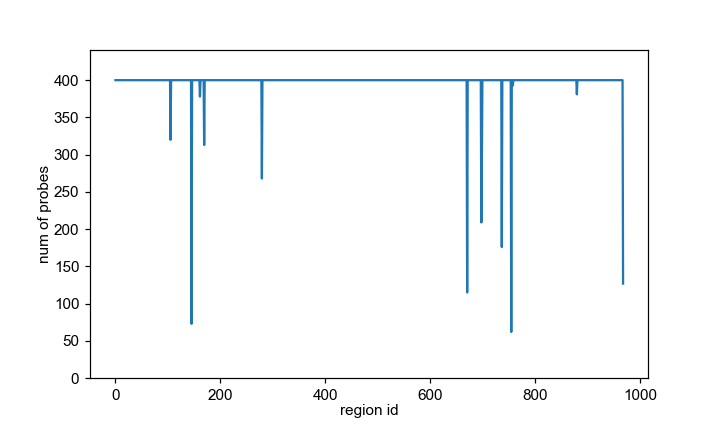

In [64]:
# plot the probe number against all regins
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

In [65]:
len(pb_num_dict)

968

In [66]:
# keep regions that have probes

filtered_reg_names = {}
for _reg, _pbde in filtered_pb_dict.items():
    if len(_pbde.kept_probes) > 0:
        filtered_reg_names[_reg] = list(_pbde.kept_probes.values())[0]['reg_name']
    
        

In [68]:
len(filtered_reg_names)

filtered_reg_names

{251: '4:105899094-105952080_strand_+_reg_251',
 252: '4:114589240-114676242_strand_+_reg_252',
 253: '4:115037700-115112192_strand_+_reg_253',
 255: '4:115837369-115913327_strand_+_reg_255',
 256: '4:116628906-116683403_strand_+_reg_256',
 257: '4:117618081-117687368_strand_+_reg_257',
 258: '4:123199825-123264995_strand_+_reg_258',
 259: '4:123961238-124063077_strand_+_reg_259',
 260: '4:124824301-124866678_strand_+_reg_260',
 261: '4:126207621-126263017_strand_+_reg_261',
 262: '4:126995025-127049608_strand_+_reg_262',
 263: '4:127493306-127563000_strand_+_reg_263',
 264: '4:127666510-127718932_strand_+_reg_264',
 265: '4:127800701-127872488_strand_+_reg_265',
 266: '4:129485757-129532804_strand_+_reg_266',
 267: '4:130236140-130307752_strand_+_reg_267',
 268: '4:130509810-130579025_strand_+_reg_268',
 269: '4:131733908-131844723_strand_+_reg_269',
 270: '4:132792079-132834284_strand_+_reg_270',
 271: '4:135807186-135873467_strand_+_reg_271',
 272: '4:137277244-137324456_strand_+_re

In [73]:
# count the region number for each chr
chr_2_region_num = {}
for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_num:
        chr_2_region_num[_chr] = 1
    else:
        chr_2_region_num[_chr] += 1


In [75]:
chr_2_region_num

{'4': 61,
 '5': 56,
 '6': 56,
 '7': 45,
 '8': 52,
 '9': 54,
 '10': 64,
 '11': 57,
 '12': 35,
 '13': 49,
 '1': 76,
 '2': 73,
 '3': 59,
 '14': 51,
 '15': 35,
 '16': 37,
 '17': 34,
 '18': 32,
 '19': 35,
 'X': 7}

In [74]:
# save region number info for chr
pickle.dump(chr_2_region_num, open(os.path.join(library_folder, 'chr_2_region_num.pkl'), 'wb'))

In [76]:
# save region name info for chr
chr_2_region_names = {}
for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_names:
        chr_2_region_names[_chr] = [_reg]
    else:
        chr_2_region_names[_chr].append(_reg)

In [77]:
chr_2_region_names

{'4': [251,
  252,
  253,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250],
 '5': [275,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  316,
  317,
  318,
  319,
  320,
  321,
  322,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  332,
  333,
  334],
 '6': [335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354,
  355,
  356,
  357,
  358,
  3

In [78]:
# save
pickle.dump(chr_2_region_names, open(os.path.join(library_folder, 'chr_2_region_names.pkl'), 'wb'))

# 3. Load and asssemble probes

## 3.1 design readout mapping dict (region_to_readout)




Generate 'region_to_readout dict' with the above 'chr_2_region_num.pkl' and 'chr_2_region_names.pkl' as inputs by using the jupyter notebook from http://localhost:8888/notebooks/Documents/Chromatin_Analysis_Scripts/Library_design/CTP13-mop-merged-1000-SE/Design_codebook_CTP13-mop-merged-1000-SE.ipynb;


Next, load the 'region_to_readout dict' in the step below and proceed.

## 3.2 loading components

### primers
pick primer set 2,9

In [4]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG')
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG')


### readouts

In [5]:
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))

In [6]:
print(len(region_2_readout_dict))

region_2_readout_dict

968


{1: ['c3', 'c47', 'c76'],
 2: ['c8', 'c54', 'c90'],
 3: ['c29', 'c69', 'c87'],
 4: ['c51', 'c65', 'c73'],
 5: ['c35', 'c53', 'c60'],
 6: ['c11', 'c18', 'c19'],
 7: ['c52', 'c62', 'c89'],
 8: ['c14', 'c30', 'c85'],
 9: ['c15', 'c63', 'c84'],
 10: ['c43', 'c68', 'c70'],
 11: ['c45', 'c57', 'c81'],
 12: ['c12', 'c79', 'c92'],
 13: ['c42', 'c47', 'c66'],
 14: ['c20', 'c21', 'c39'],
 15: ['c9', 'c71', 'c72'],
 16: ['c17', 'c31', 'c61'],
 17: ['c24', 'c74', 'c94'],
 18: ['c4', 'c28', 'c83'],
 19: ['c18', 'c41', 'c60'],
 20: ['c0', 'c27', 'c52'],
 21: ['c33', 'c59', 'c93'],
 22: ['c30', 'c75', 'c82'],
 23: ['c10', 'c34', 'c77'],
 24: ['c40', 'c55', 'c67'],
 25: ['c23', 'c32', 'c56'],
 26: ['c9', 'c22', 'c54'],
 27: ['c16', 'c44', 'c88'],
 28: ['c49', 'c63', 'c81'],
 29: ['c37', 'c39', 'c87'],
 30: ['c69', 'c74', 'c91'],
 31: ['c11', 'c12', 'c26'],
 32: ['c6', 'c50', 'c78'],
 33: ['c1', 'c13', 'c38'],
 34: ['c41', 'c84', 'c90'],
 35: ['c35', 'c36', 'c66'],
 36: ['c7', 'c30', 'c76'],
 37: ['c58

In [7]:
# collect types
# only one type for this library which is 'c'

readout_usage_by_type = {}
for _region, _infos in region_2_readout_dict.items():
    # for each bit 
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

In [40]:
#readout_usage_by_type   

In [8]:
readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}
readout_dict ={}

### readout: generate readout files if necessary


only required if relevant files have not been generated before.

In [72]:
# load source readout fasta 
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts'

# good adaptor list
snr_file_647 = 'highest_snr_647.fasta'
snr_file_750 = 'highest_snr_750.fasta'


from ImageAnalysis3.library_tools import LibraryTools
from ImageAnalysis3.library_tools.LibraryTools import fastaread, fastawrite

In [78]:
# extract adaptor names and seqs
readout_647_name, readout_647_seq = fastaread(readout_folder+os.sep+snr_file_647)
readout_750_name, readout_750_seq = fastaread(readout_folder+os.sep+snr_file_750)

In [79]:
print(len(readout_647_name))
print(len(readout_647_seq))
print(len(readout_750_name))
print(len(readout_750_seq))

149
149
150
150


In [93]:
print(readout_647_name[0])
print(readout_750_name[0])

NDB_755
NDB_784


In [99]:
# filter for channel 647: use NDB index <= 630 (as NDB >630 has been used for the compartment library design) 
readout_before_630_647_name = []
readout_before_630_647_seq = []

for _name, _seq in zip(readout_647_name, readout_647_seq):
    if int(_name.split('_')[-1])<=630:
        readout_before_630_647_name.append(_name)
        readout_before_630_647_seq.append(_seq)
        
print(readout_before_630_647_name[0])
print(readout_before_630_647_seq[0])

# filter for channel 750: use NDB index <= 630 similarly 
readout_before_630_750_name = []
readout_before_630_750_seq = []

for _name, _seq in zip(readout_750_name, readout_750_seq):
    if int(_name.split('_')[-1])<=630:
        readout_before_630_750_name.append(_name)
        readout_before_630_750_seq.append(_seq)
        
print(readout_before_630_750_name[0])
print(readout_before_630_750_seq[0])

NDB_578
TGCCACATCTAGGCGATACATGAGAGGCGT
NDB_376
CCCTAATCCCGACTTTGTGGGTACGTTGAT


In [100]:
print(len(readout_before_630_750_name))
print(len(readout_before_630_750_seq))
print(len(readout_before_630_647_name))
print(len(readout_before_630_647_seq))

57
57
68
68


In [101]:
#save the filtered readout files

# save for 750
fastawrite(readout_folder+os.sep+'snr_before_630_750.fasta',readout_before_630_750_name,readout_before_630_750_seq,append=False)
# save for 647
fastawrite(readout_folder+os.sep+'snr_before_630_647.fasta',readout_before_630_647_name,readout_before_630_647_seq,append=False)

### after generating the relevant readout files, proceed

In [9]:
reload(library_tools.assemble)
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts'
readout_start = 0
num_color = 2

# generate the 'snr_before_630_750.fasta' and 'snr_before_630_647.fasta' (see above) first before proceeding

comb_readouts = library_tools.assemble.load_readouts(readout_usage_dict['c'], 
                                                       _type='snr_before_630', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=readout_start,
                                                       )
readout_dict['c'] = comb_readouts

In [10]:
readout_dict['c']

[SeqRecord(seq=Seq('CCCTAATCCCGACTTTGTGGGTACGTTGAT'), id='NDB_376', name='NDB_376', description='NDB_376', dbxrefs=[]),
 SeqRecord(seq=Seq('TGCCACATCTAGGCGATACATGAGAGGCGT'), id='NDB_578', name='NDB_578', description='NDB_578', dbxrefs=[]),
 SeqRecord(seq=Seq('AGCCAGCTCGTAGCGCCTGAATTAGCTATA'), id='NDB_400', name='NDB_400', description='NDB_400', dbxrefs=[]),
 SeqRecord(seq=Seq('TCCGTTAAACGTCGGCTGCGTACTGGTACA'), id='NDB_533', name='NDB_533', description='NDB_533', dbxrefs=[]),
 SeqRecord(seq=Seq('TCTCAAGGTTACCGGTTGTCTATATCGTCT'), id='NDB_568', name='NDB_568', description='NDB_568', dbxrefs=[]),
 SeqRecord(seq=Seq('AGAGAGCGACTTGGGAACGCCTTCATATCC'), id='NDB_464', name='NDB_464', description='NDB_464', dbxrefs=[]),
 SeqRecord(seq=Seq('GCCGTATCAGCGTGTACGGTCAAATACGAG'), id='NDB_466', name='NDB_466', description='NDB_466', dbxrefs=[]),
 SeqRecord(seq=Seq('GGACAGGACTGTTCACCGGAATACTTCTGA'), id='NDB_431', name='NDB_431', description='NDB_431', dbxrefs=[]),
 SeqRecord(seq=Seq('GCCGATCTTTAGCGGATTAA

In [87]:
# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save


## 3.3 assemble probes

In [23]:
# assemble full-length probes using primer, readouts, and targeting regions (from filtered_pb_dict)

reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=20, 
                                               num_readout_per_probe=3, 
                                               unique_readout_per_probe=False,
                                               rc_targets=False, overwrite=True)


# candidate_probes.fasta and readout_summary.pkl are generated after this step

NameError: name 'filtered_pb_dict' is not defined

# 4.Check quality

## 4.1 Load probes

Checking procedures could restart from here

In [11]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version



# load assembled full-length probes from the "candidate_probes.fasta" file
full_records = []


with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 385098


In [12]:
num_readout_per_probe = 3
primer_len=20
target_len=42
min_num_probes = 40

### 4.1.1 check primer usage

In [13]:
# check

import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 385098
True


### 4.1.2 check region probe number

In [14]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: 251 -> 400
gene: 252 -> 400
gene: 253 -> 400
gene: 255 -> 400
gene: 256 -> 400
gene: 257 -> 400
gene: 258 -> 400
gene: 259 -> 400
gene: 260 -> 400
gene: 261 -> 400
gene: 262 -> 400
gene: 263 -> 400
gene: 264 -> 400
gene: 265 -> 400
gene: 266 -> 400
gene: 267 -> 400
gene: 268 -> 400
gene: 269 -> 400
gene: 270 -> 400
gene: 271 -> 400
gene: 272 -> 400
gene: 273 -> 400
gene: 274 -> 400
gene: 275 -> 400
gene: 277 -> 400
gene: 278 -> 400
gene: 279 -> 400
gene: 280 -> 400
gene: 281 -> 400
gene: 282 -> 400
gene: 283 -> 400
gene: 284 -> 400
gene: 285 -> 400
gene: 286 -> 400
gene: 287 -> 400
gene: 288 -> 400
gene: 289 -> 400
gene: 290 -> 400
gene: 291 -> 400
gene: 292 -> 400
gene: 293 -> 400
gene: 295 -> 400
gene: 296 -> 400
gene: 297 -> 400
gene: 298 -> 400
gene: 299 -> 400
gene: 300 -> 400
gene: 301 -> 400
gene: 302 -> 400
gene: 303 -> 400
gene: 304 -> 400
gene: 305 -> 400
gene: 306 -> 400
gene: 307 -> 400
gene: 308 -> 400
gene: 309 -> 400
gene: 310 -> 400
gene: 311 -> 400
gene: 312 -> 4

<IPython.core.display.Javascript object>


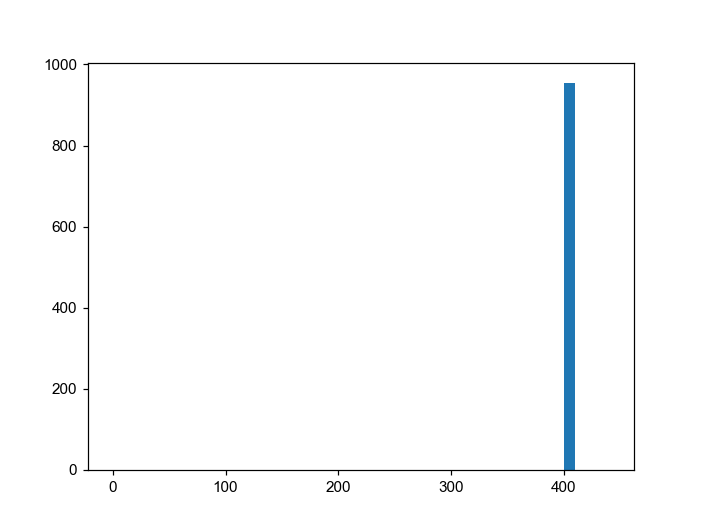

In [46]:
plt.figure()
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,450,10))
plt.show()

# majority (>900) of regions have 400 probes

### 4.1.3 check readout usage for each gene

In [16]:
num_readout_per_probe

3

In [17]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_readout_per_probe)
print(reg2readout_check)
# bit-to-adaptor usage

251 -> ['NDB_487', 'NDB_628', 'NDB_629']
252 -> ['NDB_350', 'NDB_458', 'NDB_616']
253 -> ['NDB_335', 'NDB_409', 'NDB_562']
255 -> ['NDB_439', 'NDB_443', 'NDB_532']
256 -> ['NDB_401', 'NDB_446', 'NDB_601']
257 -> ['NDB_427', 'NDB_505', 'NDB_514']
258 -> ['NDB_395', 'NDB_544', 'NDB_568']
259 -> ['NDB_391', 'NDB_445', 'NDB_557']
260 -> ['NDB_376', 'NDB_433', 'NDB_436']
261 -> ['NDB_400', 'NDB_526', 'NDB_547']
262 -> ['NDB_448', 'NDB_467', 'NDB_587']
263 -> ['NDB_385', 'NDB_491', 'NDB_563']
264 -> ['NDB_529', 'NDB_536', 'NDB_589']
265 -> ['NDB_446', 'NDB_511', 'NDB_577']
266 -> ['NDB_452', 'NDB_470', 'NDB_517']
267 -> ['NDB_386', 'NDB_551', 'NDB_581']
268 -> ['NDB_392', 'NDB_532', 'NDB_608']
269 -> ['NDB_350', 'NDB_397', 'NDB_592']
270 -> ['NDB_368', 'NDB_388', 'NDB_625']
271 -> ['NDB_371', 'NDB_443', 'NDB_614']
272 -> ['NDB_341', 'NDB_464', 'NDB_538']
273 -> ['NDB_356', 'NDB_616', 'NDB_622']
274 -> ['NDB_428', 'NDB_533', 'NDB_601']
275 -> ['NDB_376', 'NDB_445', 'NDB_538']
277 -> ['NDB_359

### 4.1.4 check readout usage in the library

In [18]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)

print(readout2reg_check)

-- extracting probes from >region:251, region:252, region:253, region:255, region:256, region:257, region:258, region:259, region:260, region:261, region:262, region:263, region:264, region:265, region:266, region:267, region:268, region:269, region:270, region:271, region:272, region:273, region:274, region:275, region:277, region:278, region:279, region:280, region:281, region:282, region:283, region:284, region:285, region:286, region:287, region:288, region:289, region:290, region:291, region:292, region:293, region:295, region:296, region:297, region:298, region:299, region:300, region:301, region:302, region:303, region:304, region:305, region:306, region:307, region:308, region:309, region:310, region:311, region:312, region:313, region:314, region:315, region:316, region:317, region:318, region:319, region:320, region:321, region:322, region:324, region:325, region:326, region:327, region:328, region:329, region:330, region:332, region:333, region:334, region:335, region:336, r

, region:206, region:207, region:208, region:209, region:210, region:211, region:212, region:213, region:214, region:215, region:216, region:217, region:218, region:219, region:220, region:221, region:222, region:223, region:224, region:225, region:226, region:228, region:229, region:230, region:231, region:232, region:233, region:234, region:235, region:236, region:237, region:238, region:239, region:240, region:241, region:242, region:243, region:244, region:245, region:246, region:247, region:248, region:249, region:250, region:751, region:752, region:758, region:759, region:760, region:761, region:762, region:763, region:764, region:765, region:766, region:767, region:768, region:769, region:770, region:772, region:773, region:774, region:775, region:776, region:777, region:778, region:779, region:780, region:781, region:782, region:783, region:784, region:785, region:786, region:787, region:788, region:789, region:790, region:791, region:792, region:793, region:794, region:795, re

### 4.1.5 check bewteen probes

In [19]:
# construct internal map
reload(check)
#int_map = check._construct_internal_map(full_records, library_folder, save=True) # file is big; not necessary to save

int_map = check._construct_internal_map(full_records, library_folder, save=False) 

In [20]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [21]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_4:105899094-105952080_gene_251_pb_112_pos_30682_strand_+_readouts_[NDB_487_c,NDB_628_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_4:105899094-105952080_gene_251_pb_113_pos_30738_strand_-_readouts_[NDB_487_c,NDB_628_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_4:114589240-114676242_gene_252_pb_154_pos_54592_strand_+_readouts_[NDB_458_c,NDB_616_c,NDB_350_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:59, dumped
--- Sequence:loc_5:3994952-4090244_gene_275_pb_58_pos_57879_strand_+_readouts_[NDB_376_c,NDB_445_c,NDB_538_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:77, dumped
--- Sequence:loc_5:3994952-4090244_gene_275_pb_59_pos_58013_strand_-_readouts_[NDB_376_c,NDB_445_c,NDB_538_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:97, dumped
--- Sequence:loc_5:3994952-4090244_gene_275_pb_60_pos_58151_strand_-_readouts_[NDB_376_c,NDB_445_c,NDB_538_c]_primers_[W1A03_primer_2,W

--- Sequence:loc_6:128391401-128443169_gene_382_pb_377_pos_49338_strand_-_readouts_[NDB_482_c,NDB_577_c,NDB_493_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:81, dumped
--- Sequence:loc_6:128391401-128443169_gene_382_pb_378_pos_49443_strand_+_readouts_[NDB_482_c,NDB_577_c,NDB_493_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:72, dumped
--- Sequence:loc_6:128391401-128443169_gene_382_pb_379_pos_49583_strand_-_readouts_[NDB_482_c,NDB_577_c,NDB_493_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:108, dumped
--- Sequence:loc_6:128391401-128443169_gene_382_pb_380_pos_49632_strand_+_readouts_[NDB_482_c,NDB_577_c,NDB_493_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:86, dumped
--- Sequence:loc_6:128391401-128443169_gene_382_pb_381_pos_49842_strand_+_readouts_[NDB_482_c,NDB_577_c,NDB_493_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:76, dumped
--- Sequence:loc_6:128391401-128443169_gene_382_pb_382_pos_49887_strand_+_readouts_[NDB_482_c,NDB_577_c,NDB_493_c]_primers_[

--- Sequence:loc_7:64285872-64371201_gene_405_pb_343_pos_80521_strand_+_readouts_[NDB_455_c,NDB_356_c,NDB_551_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_7:64285872-64371201_gene_405_pb_344_pos_80576_strand_+_readouts_[NDB_455_c,NDB_356_c,NDB_551_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:65, dumped
--- Sequence:loc_7:83790534-83849178_gene_413_pb_114_pos_35047_strand_+_readouts_[NDB_332_c,NDB_517_c,NDB_365_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:149, dumped
--- Sequence:loc_7:83790534-83849178_gene_413_pb_115_pos_35153_strand_-_readouts_[NDB_332_c,NDB_517_c,NDB_365_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:168, dumped
--- Sequence:loc_7:83790534-83849178_gene_413_pb_116_pos_35207_strand_-_readouts_[NDB_332_c,NDB_517_c,NDB_365_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:146, dumped
--- Sequence:loc_7:83790534-83849178_gene_413_pb_117_pos_35466_strand_-_readouts_[NDB_332_c,NDB_517_c,NDB_365_c]_primers_[W1A03_prim

--- Sequence:loc_8:78008249-78074137_gene_465_pb_211_pos_48574_strand_+_readouts_[NDB_554_c,NDB_577_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:68, dumped
--- Sequence:loc_8:78008249-78074137_gene_465_pb_212_pos_48618_strand_+_readouts_[NDB_554_c,NDB_577_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_8:79321964-79402981_gene_466_pb_205_pos_57384_strand_+_readouts_[NDB_335_c,NDB_557_c,NDB_547_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:75, dumped
--- Sequence:loc_8:79321964-79402981_gene_466_pb_206_pos_57533_strand_+_readouts_[NDB_335_c,NDB_557_c,NDB_547_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_8:79321964-79402981_gene_466_pb_208_pos_57665_strand_+_readouts_[NDB_335_c,NDB_557_c,NDB_547_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:73, dumped
--- Sequence:loc_8:90827081-90904757_gene_473_pb_85_pos_42216_strand_+_readouts_[NDB_400_c,NDB_487_c,NDB_551_c]_primers_[W1A03_primer_2

--- Sequence:loc_10:23181367-23277580_gene_552_pb_354_pos_92946_strand_+_readouts_[NDB_397_c,NDB_539_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_10:23181367-23277580_gene_552_pb_358_pos_93152_strand_+_readouts_[NDB_397_c,NDB_539_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:76, dumped
--- Sequence:loc_10:23181367-23277580_gene_552_pb_359_pos_93196_strand_+_readouts_[NDB_397_c,NDB_539_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:118, dumped
--- Sequence:loc_10:23181367-23277580_gene_552_pb_360_pos_93240_strand_+_readouts_[NDB_397_c,NDB_539_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:117, dumped
--- Sequence:loc_10:23181367-23277580_gene_552_pb_361_pos_93353_strand_+_readouts_[NDB_397_c,NDB_539_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:140, dumped
--- Sequence:loc_10:23181367-23277580_gene_552_pb_362_pos_93433_strand_+_readouts_[NDB_397_c,NDB_539_c,NDB_368_c]_primers_[W1A0

--- Sequence:loc_11:63881715-63935692_gene_640_pb_84_pos_31149_strand_+_readouts_[NDB_458_c,NDB_467_c,NDB_401_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_11:63881715-63935692_gene_640_pb_85_pos_31194_strand_+_readouts_[NDB_458_c,NDB_467_c,NDB_401_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_11:63881715-63935692_gene_640_pb_87_pos_31372_strand_+_readouts_[NDB_458_c,NDB_467_c,NDB_401_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:71, dumped
--- Sequence:loc_12:12755678-12838753_gene_672_pb_237_pos_60206_strand_+_readouts_[NDB_455_c,NDB_391_c,NDB_628_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_12:12755678-12838753_gene_672_pb_238_pos_60252_strand_+_readouts_[NDB_455_c,NDB_391_c,NDB_628_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_12:45004756-45093297_gene_679_pb_261_pos_65287_strand_+_readouts_[NDB_376_c,NDB_511_c,NDB_473_c]_primers_[W1A03_prim

--- Sequence:loc_13:99342904-99407764_gene_740_pb_165_pos_45941_strand_+_readouts_[NDB_431_c,NDB_538_c,NDB_460_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:140, dumped
--- Sequence:loc_13:99342904-99407764_gene_740_pb_166_pos_45992_strand_+_readouts_[NDB_431_c,NDB_538_c,NDB_460_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:100, dumped
--- Sequence:loc_13:99342904-99407764_gene_740_pb_167_pos_46041_strand_+_readouts_[NDB_431_c,NDB_538_c,NDB_460_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:90, dumped
--- Sequence:loc_13:99342904-99407764_gene_740_pb_168_pos_46103_strand_+_readouts_[NDB_431_c,NDB_538_c,NDB_460_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:80, dumped
--- Sequence:loc_13:99342904-99407764_gene_740_pb_169_pos_46174_strand_-_readouts_[NDB_431_c,NDB_538_c,NDB_460_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:94, dumped
--- Sequence:loc_13:99342904-99407764_gene_740_pb_170_pos_46223_strand_+_readouts_[NDB_431_c,NDB_538_c,NDB_460_c]_primers_[W1A03

--- Sequence:loc_1:9749317-9845402_gene_2_pb_260_pos_76489_strand_+_readouts_[NDB_511_c,NDB_418_c,NDB_592_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:55, dumped
--- Sequence:loc_1:9749317-9845402_gene_2_pb_261_pos_76536_strand_+_readouts_[NDB_511_c,NDB_418_c,NDB_592_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:60, dumped
--- Sequence:loc_1:42219499-42273271_gene_14_pb_67_pos_26949_strand_-_readouts_[NDB_508_c,NDB_536_c,NDB_473_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:66, dumped
--- Sequence:loc_1:42219499-42273271_gene_14_pb_68_pos_27068_strand_-_readouts_[NDB_508_c,NDB_536_c,NDB_473_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:67, dumped
--- Sequence:loc_1:54779256-54924777_gene_19_pb_357_pos_103071_strand_-_readouts_[NDB_529_c,NDB_539_c,NDB_622_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_1:54779256-54924777_gene_19_pb_359_pos_103275_strand_-_readouts_[NDB_529_c,NDB_539_c,NDB_622_c]_primers_[W1A03_primer_2,W1A10_prim

--- Sequence:loc_2:135648540-135694141_gene_131_pb_225_pos_29446_strand_+_readouts_[NDB_403_c,NDB_467_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:71, dumped
--- Sequence:loc_2:135648540-135694141_gene_131_pb_227_pos_29641_strand_-_readouts_[NDB_403_c,NDB_467_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:64, dumped
--- Sequence:loc_2:135648540-135694141_gene_131_pb_228_pos_30331_strand_+_readouts_[NDB_403_c,NDB_467_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:67, dumped
--- Sequence:loc_2:135648540-135694141_gene_131_pb_229_pos_30495_strand_+_readouts_[NDB_403_c,NDB_467_c,NDB_368_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_2:143965229-144015150_gene_135_pb_68_pos_24140_strand_-_readouts_[NDB_571_c,NDB_506_c,NDB_401_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_2:148667886-148731885_gene_138_pb_50_pos_33407_strand_+_readouts_[NDB_526_c,NDB_386_c,NDB_563_c]_primers_[W1A

--- Sequence:loc_3:103092173-103150905_gene_192_pb_229_pos_41699_strand_+_readouts_[NDB_571_c,NDB_556_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_3:103092173-103150905_gene_192_pb_230_pos_41746_strand_-_readouts_[NDB_571_c,NDB_556_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_3:103092173-103150905_gene_192_pb_236_pos_42537_strand_-_readouts_[NDB_571_c,NDB_556_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:68, dumped
--- Sequence:loc_3:103092173-103150905_gene_192_pb_237_pos_43285_strand_+_readouts_[NDB_571_c,NDB_556_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_3:103092173-103150905_gene_192_pb_238_pos_43669_strand_-_readouts_[NDB_571_c,NDB_556_c,NDB_629_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:67, dumped
--- Sequence:loc_3:103092173-103150905_gene_192_pb_239_pos_43787_strand_-_readouts_[NDB_571_c,NDB_556_c,NDB_629_c]_primers_[W

--- Sequence:loc_14:31127141-31206382_gene_766_pb_127_pos_47424_strand_-_readouts_[NDB_554_c,NDB_473_c,NDB_544_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_14:31127141-31206382_gene_766_pb_128_pos_47468_strand_-_readouts_[NDB_554_c,NDB_473_c,NDB_544_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:61, dumped
--- Sequence:loc_14:31127141-31206382_gene_766_pb_129_pos_47550_strand_-_readouts_[NDB_554_c,NDB_473_c,NDB_544_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:85, dumped
--- Sequence:loc_14:40891564-40969316_gene_770_pb_280_pos_69786_strand_-_readouts_[NDB_458_c,NDB_514_c,NDB_359_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:78, dumped
--- Sequence:loc_14:40891564-40969316_gene_770_pb_281_pos_69943_strand_+_readouts_[NDB_458_c,NDB_514_c,NDB_359_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:93, dumped
--- Sequence:loc_14:40891564-40969316_gene_770_pb_282_pos_69991_strand_+_readouts_[NDB_458_c,NDB_514_c,NDB_359_c]_primers_[W1A03_p

--- Sequence:loc_15:58158195-58230642_gene_826_pb_368_pos_68569_strand_+_readouts_[NDB_476_c,NDB_601_c,NDB_608_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_15:58158195-58230642_gene_826_pb_369_pos_68617_strand_+_readouts_[NDB_476_c,NDB_601_c,NDB_608_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_15:81672506-81729092_gene_835_pb_229_pos_42048_strand_+_readouts_[NDB_554_c,NDB_619_c,NDB_395_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:67, dumped
--- Sequence:loc_15:81672506-81729092_gene_835_pb_230_pos_42136_strand_+_readouts_[NDB_554_c,NDB_619_c,NDB_395_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:66, dumped
--- Sequence:loc_15:81672506-81729092_gene_835_pb_232_pos_42438_strand_+_readouts_[NDB_554_c,NDB_619_c,NDB_395_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:64, dumped
--- Sequence:loc_15:92180253-92287287_gene_839_pb_13_pos_54258_strand_-_readouts_[NDB_379_c,NDB_386_c,NDB_556_c]_primers_[W1A03_pr

--- Sequence:loc_18:53219139-53335927_gene_937_pb_265_pos_84933_strand_-_readouts_[NDB_356_c,NDB_418_c,NDB_625_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:55, dumped
--- Sequence:loc_18:53219139-53335927_gene_937_pb_268_pos_85385_strand_-_readouts_[NDB_356_c,NDB_418_c,NDB_625_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_18:53219139-53335927_gene_937_pb_269_pos_85468_strand_-_readouts_[NDB_356_c,NDB_418_c,NDB_625_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_18:63719174-63787284_gene_941_pb_296_pos_57281_strand_+_readouts_[NDB_536_c,NDB_539_c,NDB_628_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_18:63719174-63787284_gene_941_pb_298_pos_57390_strand_-_readouts_[NDB_536_c,NDB_539_c,NDB_628_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_18:77958807-78042826_gene_947_pb_5_pos_43354_strand_-_readouts_[NDB_347_c,NDB_491_c,NDB_547_c]_primers_[W1A03_pri

In [22]:
del(int_map)

### 4.1.6 finish checking, save

In [23]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

the local database is created as follows (with first downloading the Mus_musculus.GRCm38.dna_sm.merged.fa in the path as indicated)

example for creating the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```


these pre-generated blast files are now located in the NAS2.

blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')




Other tips for running and installing the blastn

Installation instrucntion:
see instruction: https://www.ncbi.nlm.nih.gov/books/NBK52637/

in cmd using the below command (refer to instrcution for how to use)


use cmd to open jupyter so that blastn -h can be found by jupyter (need to use cmd to restart jupyter after first-time installing)


In [47]:
# if blastn is installed and can be found by jupyter, the below command will show the help page for blastn
!blastn -h

USAGE
  blastn [-h] [-help] [-import_search_strategy filename]
    [-export_search_strategy filename] [-task task_name] [-db database_name]
    [-dbsize num_letters] [-gilist filename] [-seqidlist filename]
    [-negative_gilist filename] [-negative_seqidlist filename]
    [-taxids taxids] [-negative_taxids taxids] [-taxidlist filename]
    [-negative_taxidlist filename] [-entrez_query entrez_query]
    [-db_soft_mask filtering_algorithm] [-db_hard_mask filtering_algorithm]
    [-subject subject_input_file] [-subject_loc range] [-query input_file]
    [-out output_file] [-evalue evalue] [-word_size int_value]
    [-gapopen open_penalty] [-gapextend extend_penalty]
    [-perc_identity float_value] [-qcov_hsp_perc float_value]
    [-max_hsps int_value] [-xdrop_ungap float_value] [-xdrop_gap float_value]
    [-xdrop_gap_final float_value] [-searchsp int_value]
    [-sum_stats bool_value] [-penalty penalty] [-reward reward] [-no_greedy]
    [-min_raw_gapped_score int_value] [-template_type

In [25]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

# run blast using the pre-generated blastn database (on NAS2)
check.Blast_probes(kept_records, library_folder, num_threads=32, 
                   blast_db=blast_database, blast_evalue=100, overwrite=True)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 383682
-- processing region: 1 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_1.fasta
--- *blasting region: 1
--- total time for blast 1: 24.73100185394287
-- processing region: 10 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_10.fasta
--- *blasting region: 10
--- total time for blast 10: 24.191994190216064
-- processing region: 100 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_100.fasta
--- *blasting region: 100
--- total time for blast 100: 26.69500231742859
-- processing region: 101 with 400 probes
--- *writing file: \\10.245.74.212\C

--- total time for blast 129: 16.280003309249878
-- processing region: 13 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_13.fasta
--- *blasting region: 13
--- total time for blast 13: 21.118999242782593
-- processing region: 130 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_130.fasta
--- *blasting region: 130
--- total time for blast 130: 19.21800422668457
-- processing region: 131 with 396 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_131.fasta
--- *blasting region: 131
--- total time for blast 131: 22.153993844985962
-- processing region: 132 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_132.fasta
--- *bl

--- total time for blast 159: 18.79399585723877
-- processing region: 16 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_16.fasta
--- *blasting region: 16
--- total time for blast 16: 21.981003999710083
-- processing region: 160 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_160.fasta
--- *blasting region: 160
--- total time for blast 160: 20.894002676010132
-- processing region: 161 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_161.fasta
--- *blasting region: 161
--- total time for blast 161: 20.9749972820282
-- processing region: 162 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_162.fasta
--- *blas

--- total time for blast 19: 16.72299861907959
-- processing region: 190 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_190.fasta
--- *blasting region: 190
--- total time for blast 190: 26.29800033569336
-- processing region: 191 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_191.fasta
--- *blasting region: 191
--- total time for blast 191: 18.600998878479004
-- processing region: 192 with 394 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_192.fasta
--- *blasting region: 192
--- total time for blast 192: 19.421009302139282
-- processing region: 193 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_193.fasta
--- *

--- total time for blast 219: 17.724000692367554
-- processing region: 22 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_22.fasta
--- *blasting region: 22
--- total time for blast 22: 20.75999927520752
-- processing region: 220 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_220.fasta
--- *blasting region: 220
--- total time for blast 220: 19.317882776260376
-- processing region: 221 with 397 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_221.fasta
--- *blasting region: 221
--- total time for blast 221: 23.335996627807617
-- processing region: 222 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_222.fasta
--- *bl

--- total time for blast 25: 20.009997367858887
-- processing region: 250 with 393 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_250.fasta
--- *blasting region: 250
--- total time for blast 250: 20.47700333595276
-- processing region: 251 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_251.fasta
--- *blasting region: 251
--- total time for blast 251: 21.841999530792236
-- processing region: 252 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_252.fasta
--- *blasting region: 252
--- total time for blast 252: 20.899006128311157
-- processing region: 253 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_253.fasta
--- 

--- total time for blast 281: 21.03499937057495
-- processing region: 282 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_282.fasta
--- *blasting region: 282
--- total time for blast 282: 22.525002241134644
-- processing region: 283 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_283.fasta
--- *blasting region: 283
--- total time for blast 283: 25.907999753952026
-- processing region: 284 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_284.fasta
--- *blasting region: 284
--- total time for blast 284: 24.386038780212402
-- processing region: 285 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_285.fasta
---

--- total time for blast 311: 24.802997589111328
-- processing region: 312 with 390 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_312.fasta
--- *blasting region: 312
--- total time for blast 312: 20.8849995136261
-- processing region: 313 with 396 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_313.fasta
--- *blasting region: 313
--- total time for blast 313: 22.261006593704224
-- processing region: 314 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_314.fasta
--- *blasting region: 314
--- total time for blast 314: 21.9129958152771
-- processing region: 315 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_315.fasta
--- *b

--- total time for blast 343: 23.857993602752686
-- processing region: 344 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_344.fasta
--- *blasting region: 344
--- total time for blast 344: 17.863003730773926
-- processing region: 345 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_345.fasta
--- *blasting region: 345
--- total time for blast 345: 19.348004817962646
-- processing region: 347 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_347.fasta
--- *blasting region: 347
--- total time for blast 347: 24.83999514579773
-- processing region: 348 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_348.fasta
---

--- total time for blast 374: 20.622997283935547
-- processing region: 375 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_375.fasta
--- *blasting region: 375
--- total time for blast 375: 22.125991106033325
-- processing region: 376 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_376.fasta
--- *blasting region: 376
--- total time for blast 376: 20.61100745201111
-- processing region: 377 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_377.fasta
--- *blasting region: 377
--- total time for blast 377: 16.78899908065796
-- processing region: 378 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_378.fasta
--- 

--- total time for blast 403: 19.363012552261353
-- processing region: 404 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_404.fasta
--- *blasting region: 404
--- total time for blast 404: 45.67299246788025
-- processing region: 405 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_405.fasta
--- *blasting region: 405
--- total time for blast 405: 87.3990044593811
-- processing region: 406 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_406.fasta
--- *blasting region: 406
--- total time for blast 406: 19.069997310638428
-- processing region: 407 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_407.fasta
--- *

--- total time for blast 433: 19.697998523712158
-- processing region: 434 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_434.fasta
--- *blasting region: 434
--- total time for blast 434: 19.153003454208374
-- processing region: 435 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_435.fasta
--- *blasting region: 435
--- total time for blast 435: 20.640995502471924
-- processing region: 436 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_436.fasta
--- *blasting region: 436
--- total time for blast 436: 23.175003051757812
-- processing region: 437 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_437.fasta
--

--- total time for blast 464: 21.1289963722229
-- processing region: 465 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_465.fasta
--- *blasting region: 465
--- total time for blast 465: 21.710994958877563
-- processing region: 466 with 397 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_466.fasta
--- *blasting region: 466
--- total time for blast 466: 21.301008462905884
-- processing region: 467 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_467.fasta
--- *blasting region: 467
--- total time for blast 467: 27.955992937088013
-- processing region: 468 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_468.fasta
--- 

--- total time for blast 495: 19.737996816635132
-- processing region: 496 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_496.fasta
--- *blasting region: 496
--- total time for blast 496: 27.204996824264526
-- processing region: 497 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_497.fasta
--- *blasting region: 497
--- total time for blast 497: 19.64200234413147
-- processing region: 498 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_498.fasta
--- *blasting region: 498
--- total time for blast 498: 19.937997817993164
-- processing region: 499 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_499.fasta
---

--- total time for blast 525: 26.47499179840088
-- processing region: 526 with 391 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_526.fasta
--- *blasting region: 526
--- total time for blast 526: 22.21499752998352
-- processing region: 527 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_527.fasta
--- *blasting region: 527
--- total time for blast 527: 24.63500213623047
-- processing region: 528 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_528.fasta
--- *blasting region: 528
--- total time for blast 528: 22.26599669456482
-- processing region: 529 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_529.fasta
--- *b

--- total time for blast 555: 17.152002096176147
-- processing region: 556 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_556.fasta
--- *blasting region: 556
--- total time for blast 556: 18.621997356414795
-- processing region: 557 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_557.fasta
--- *blasting region: 557
--- total time for blast 557: 17.12200665473938
-- processing region: 558 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_558.fasta
--- *blasting region: 558
--- total time for blast 558: 30.1439950466156
-- processing region: 559 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_559.fasta
--- *

--- total time for blast 586: 19.39200472831726
-- processing region: 587 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_587.fasta
--- *blasting region: 587
--- total time for blast 587: 21.81799864768982
-- processing region: 588 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_588.fasta
--- *blasting region: 588
--- total time for blast 588: 21.7630033493042
-- processing region: 589 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_589.fasta
--- *blasting region: 589
--- total time for blast 589: 22.757996320724487
-- processing region: 59 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_59.fasta
--- *bla

--- total time for blast 615: 21.493998289108276
-- processing region: 616 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_616.fasta
--- *blasting region: 616
--- total time for blast 616: 21.225000858306885
-- processing region: 617 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_617.fasta
--- *blasting region: 617
--- total time for blast 617: 21.38000226020813
-- processing region: 618 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_618.fasta
--- *blasting region: 618
--- total time for blast 618: 28.243000984191895
-- processing region: 619 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_619.fasta
---

--- total time for blast 645: 25.634000778198242
-- processing region: 646 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_646.fasta
--- *blasting region: 646
--- total time for blast 646: 21.54800033569336
-- processing region: 647 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_647.fasta
--- *blasting region: 647
--- total time for blast 647: 18.902992963790894
-- processing region: 648 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_648.fasta
--- *blasting region: 648
--- total time for blast 648: 18.980002403259277
-- processing region: 649 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_649.fasta
---

--- total time for blast 675: 19.80799627304077
-- processing region: 676 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_676.fasta
--- *blasting region: 676
--- total time for blast 676: 24.856002807617188
-- processing region: 677 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_677.fasta
--- *blasting region: 677
--- total time for blast 677: 18.97099995613098
-- processing region: 678 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_678.fasta
--- *blasting region: 678
--- total time for blast 678: 23.386000871658325
-- processing region: 679 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_679.fasta
--- 

--- total time for blast 705: 20.59500551223755
-- processing region: 706 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_706.fasta
--- *blasting region: 706
--- total time for blast 706: 20.11000156402588
-- processing region: 707 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_707.fasta
--- *blasting region: 707
--- total time for blast 707: 25.738994359970093
-- processing region: 708 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_708.fasta
--- *blasting region: 708
--- total time for blast 708: 21.432005405426025
-- processing region: 709 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_709.fasta
--- 

--- total time for blast 735: 19.290997982025146
-- processing region: 736 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_736.fasta
--- *blasting region: 736
--- total time for blast 736: 23.29500436782837
-- processing region: 737 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_737.fasta
--- *blasting region: 737
--- total time for blast 737: 24.623006343841553
-- processing region: 738 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_738.fasta
--- *blasting region: 738
--- total time for blast 738: 18.361997842788696
-- processing region: 739 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_739.fasta
---

--- total time for blast 77: 22.16200351715088
-- processing region: 770 with 395 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_770.fasta
--- *blasting region: 770
--- total time for blast 770: 28.144004821777344
-- processing region: 772 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_772.fasta
--- *blasting region: 772
--- total time for blast 772: 18.067042589187622
-- processing region: 773 with 393 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_773.fasta
--- *blasting region: 773
--- total time for blast 773: 20.515958070755005
-- processing region: 774 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_774.fasta
--- 

--- total time for blast 80: 23.686004161834717
-- processing region: 800 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_800.fasta
--- *blasting region: 800
--- total time for blast 800: 17.485002040863037
-- processing region: 801 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_801.fasta
--- *blasting region: 801
--- total time for blast 801: 23.689998149871826
-- processing region: 802 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_802.fasta
--- *blasting region: 802
--- total time for blast 802: 19.53100275993347
-- processing region: 803 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_803.fasta
--- 

--- total time for blast 83: 18.2479989528656
-- processing region: 830 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_830.fasta
--- *blasting region: 830
--- total time for blast 830: 21.253000736236572
-- processing region: 831 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_831.fasta
--- *blasting region: 831
--- total time for blast 831: 19.77999997138977
-- processing region: 832 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_832.fasta
--- *blasting region: 832
--- total time for blast 832: 19.68900227546692
-- processing region: 833 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_833.fasta
--- *bl

--- total time for blast 86: 24.695997714996338
-- processing region: 860 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_860.fasta
--- *blasting region: 860
--- total time for blast 860: 19.443997859954834
-- processing region: 861 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_861.fasta
--- *blasting region: 861
--- total time for blast 861: 19.163002252578735
-- processing region: 862 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_862.fasta
--- *blasting region: 862
--- total time for blast 862: 19.663000345230103
-- processing region: 863 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_863.fasta
---

--- total time for blast 890: 22.603004455566406
-- processing region: 891 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_891.fasta
--- *blasting region: 891
--- total time for blast 891: 18.892990350723267
-- processing region: 892 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_892.fasta
--- *blasting region: 892
--- total time for blast 892: 15.838002681732178
-- processing region: 893 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_893.fasta
--- *blasting region: 893
--- total time for blast 893: 18.037002325057983
-- processing region: 894 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_894.fasta
--

--- total time for blast 92: 24.04099202156067
-- processing region: 920 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_920.fasta
--- *blasting region: 920
--- total time for blast 920: 28.77600622177124
-- processing region: 921 with 396 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_921.fasta
--- *blasting region: 921
--- total time for blast 921: 22.741003036499023
-- processing region: 922 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_922.fasta
--- *blasting region: 922
--- total time for blast 922: 21.16900134086609
-- processing region: 923 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_923.fasta
--- *b

--- total time for blast 950: 21.19000482559204
-- processing region: 951 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_951.fasta
--- *blasting region: 951
--- total time for blast 951: 17.663996934890747
-- processing region: 952 with 394 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_952.fasta
--- *blasting region: 952
--- total time for blast 952: 19.011997938156128
-- processing region: 953 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_953.fasta
--- *blasting region: 953
--- total time for blast 953: 21.160009145736694
-- processing region: 954 with 397 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_954.fasta
---

--- total time for blast 980: 19.98399519920349
-- processing region: 981 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_981.fasta
--- *blasting region: 981
--- total time for blast 981: 19.20900845527649
-- processing region: 982 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_982.fasta
--- *blasting region: 982
--- total time for blast 982: 18.042001485824585
-- processing region: 983 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_983.fasta
--- *blasting region: 983
--- total time for blast 983: 21.304999828338623
-- processing region: 984 with 398 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\blast\probe_gene_984.fasta
--- 

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer (default) hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer (default) off-target hits, if exceed certain amount then dump the probe

In [26]:
# screen
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

# the max number to keep for each region
num_probes_per_region = 120

# the screen step also keeps probes close to the center of each region
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )

- Number of probes loaded: 383682
- Number of regions in this library: 968
-- checking probes in region: 251
--- gene=251, id=162 removed by soft count = 61
--- gene=251, id=281 removed by soft count = 186
--- number of probes: 398 , kept by blast: 396 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 252
--- number of probes: 399 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 253
--- gene=253, id=36 removed by soft count = 74
--- gene=253, id=38 removed by soft count = 74
--- gene=253, id=346 removed by soft count = 83
--- gene=253, id=347 removed by soft count = 78
--- gene=253, id=360 removed by soft count = 51
--- gene=253, id=361 removed by soft count = 70
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated p

--- gene=269, id=183 removed by soft count = 142
--- gene=269, id=191 removed by soft count = 108
--- gene=269, id=273 removed by soft count = 93
--- number of probes: 400 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 270
--- gene=270, id=81 removed by soft count = 428
--- gene=270, id=82 removed by soft count = 341
--- gene=270, id=139 removed by soft count = 181
--- gene=270, id=170 removed by soft count = 51
--- gene=270, id=244 removed by soft count = 160
--- gene=270, id=254 removed by soft count = 160
--- gene=270, id=256 removed by soft count = 88
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 271
--- gene=271, id=57 removed by soft count = 59
--- gene=271, id=140 removed by soft count = 235
---

--- gene=285, id=86 removed by soft count = 134
--- gene=285, id=109 removed by soft count = 63
--- gene=285, id=340 removed by soft count = 75
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 286
--- gene=286, id=128 removed by soft count = 295
--- gene=286, id=154 removed by soft count = 238
--- gene=286, id=204 removed by soft count = 125
--- gene=286, id=205 removed by soft count = 85
--- gene=286, id=209 removed by soft count = 1352
--- gene=286, id=212 removed by soft count = 681
--- gene=286, id=266 removed by soft count = 179
--- gene=286, id=269 removed by soft count = 118
--- gene=286, id=382 removed by soft count = 114
--- gene=286, id=384 removed by soft count = 195
--- gene=286, id=389 removed by soft count = 82
--- gene=286, id=391 removed by soft count = 118
--- number of probes: 400 , kept by blast: 388 , if remove du

--- gene=304, id=276 removed by soft count = 1095
--- gene=304, id=304 removed by soft count = 67
--- gene=304, id=392 removed by soft count = 57
--- number of probes: 400 , kept by blast: 397 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 305
--- gene=305, id=266 removed by soft count = 74
--- gene=305, id=281 removed by soft count = 54
--- number of probes: 399 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 306
--- gene=306, id=31 removed by soft count = 66
--- gene=306, id=329 removed by soft count = 2103
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 307
--- gene=307, id=59 removed by soft c

--- gene=322, id=385 removed by soft count = 102
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 324
--- gene=324, id=50 removed by soft count = 157
--- gene=324, id=106 removed by soft count = 59
--- gene=324, id=123 removed by soft count = 78
--- gene=324, id=199 removed by soft count = 341
--- gene=324, id=305 removed by hard count = 3
--- gene=324, id=321 removed by soft count = 102
--- gene=324, id=395 removed by soft count = 76
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 325
--- gene=325, id=255 removed by soft count = 52
--- gene=325, id=266 removed by soft count = 118
--- gene=325, id=356 removed by soft count = 65
--- number of probes: 400 , kept by blast: 397 , if r

--- number of probes: 399 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 344
--- gene=344, id=25 removed by soft count = 86
--- gene=344, id=26 removed by soft count = 99
--- gene=344, id=317 removed by soft count = 91
--- gene=344, id=374 removed by soft count = 427
--- gene=344, id=388 removed by soft count = 55
--- gene=344, id=390 removed by soft count = 219
--- gene=344, id=395 removed by soft count = 133
--- gene=344, id=398 removed by soft count = 118
--- number of probes: 400 , kept by blast: 392 , if remove dups: 391
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 345
--- gene=345, id=124 removed by soft count = 57
--- gene=345, id=291 removed by soft count = 54
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- 

--- gene=363, id=159 removed by soft count = 90
--- gene=363, id=258 removed by soft count = 55
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 364
--- gene=364, id=110 removed by soft count = 104
--- gene=364, id=254 removed by soft count = 76
--- gene=364, id=269 removed by soft count = 98
--- number of probes: 376 , kept by blast: 373 , if remove dups: 373
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 365
--- gene=365, id=12 removed by soft count = 646
--- gene=365, id=31 removed by soft count = 101
--- gene=365, id=49 removed by soft count = 153
--- gene=365, id=51 removed by soft count = 222
--- gene=365, id=122 removed by soft count = 109
--- gene=365, id=131 removed by soft count = 63
--- gene=365, id=135 removed by soft count = 72
--- ge

--- gene=383, id=318 removed by soft count = 205
--- gene=383, id=328 removed by soft count = 208
--- gene=383, id=358 removed by soft count = 60
--- gene=383, id=359 removed by soft count = 487
--- gene=383, id=365 removed by soft count = 469
--- gene=383, id=366 removed by soft count = 414
--- gene=383, id=384 removed by soft count = 75
--- gene=383, id=385 removed by soft count = 236
--- gene=383, id=389 removed by soft count = 79
--- gene=383, id=390 removed by soft count = 101
--- number of probes: 400 , kept by blast: 378 , if remove dups: 378
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 384
--- gene=384, id=22 removed by soft count = 88
--- gene=384, id=117 removed by soft count = 220
--- gene=384, id=126 removed by soft count = 172
--- gene=384, id=224 removed by soft count = 55
--- gene=384, id=269 removed by soft count = 200
--- gene=384, id=323 removed by soft count = 88
--- gene=384, i

--- gene=397, id=208 removed by soft count = 143
--- gene=397, id=329 removed by soft count = 462
--- gene=397, id=386 removed by soft count = 370
--- number of probes: 400 , kept by blast: 396 , if remove dups: 390
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 398
--- gene=398, id=170 removed by soft count = 127
--- number of probes: 400 , kept by blast: 399 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 399
--- gene=399, id=279 removed by soft count = 63
--- gene=399, id=363 removed by soft count = 58
--- gene=399, id=393 removed by soft count = 299
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 400
--- gene=400, id=229 removed by sof

--- gene=415, id=276 removed by soft count = 391
--- gene=415, id=279 removed by soft count = 716
--- gene=415, id=280 removed by soft count = 159
--- number of probes: 400 , kept by blast: 379 , if remove dups: 378
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 416
--- gene=416, id=64 removed by soft count = 173
--- gene=416, id=70 removed by soft count = 2049
--- gene=416, id=73 removed by soft count = 79
--- gene=416, id=75 removed by soft count = 864
--- gene=416, id=123 removed by soft count = 1054
--- gene=416, id=160 removed by hard count = 0
--- gene=416, id=275 removed by soft count = 171
--- gene=416, id=298 removed by soft count = 463
--- number of probes: 400 , kept by blast: 392 , if remove dups: 392
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 417
--- gene=417, id=182 removed by soft count = 69
--

--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 432
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 433
--- gene=433, id=42 removed by soft count = 4061
--- gene=433, id=315 removed by soft count = 756
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 434
--- gene=434, id=339 removed by soft count = 633
--- gene=434, id=340 removed by soft count = 140
--- gene=434, id=367 removed by soft count = 68
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- n

--- gene=454, id=10 removed by soft count = 101
--- gene=454, id=12 removed by soft count = 302
--- gene=454, id=286 removed by soft count = 75
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 455
--- gene=455, id=37 removed by soft count = 54
--- gene=455, id=83 removed by soft count = 175
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 456
--- gene=456, id=35 removed by soft count = 125
--- gene=456, id=370 removed by soft count = 77
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 457
--- gene=457, id=2 removed by soft count 

--- gene=473, id=329 removed by soft count = 101
--- number of probes: 399 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 474
--- gene=474, id=339 removed by soft count = 721
--- gene=474, id=356 removed by soft count = 212
--- gene=474, id=384 removed by soft count = 56
--- number of probes: 400 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 475
--- gene=475, id=80 removed by soft count = 60
--- gene=475, id=124 removed by soft count = 220
--- gene=475, id=343 removed by soft count = 566
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 476
--- gene=476, id=74 removed by soft 

--- gene=493, id=232 removed by soft count = 109
--- gene=493, id=264 removed by soft count = 63
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 494
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 495
--- gene=495, id=2 removed by soft count = 89
--- gene=495, id=71 removed by soft count = 139
--- gene=495, id=265 removed by soft count = 52
--- gene=495, id=329 removed by soft count = 63
--- gene=495, id=382 removed by soft count = 56
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 496
--- gene=496, id=137 removed by soft coun

--- gene=513, id=171 removed by soft count = 67
--- gene=513, id=194 removed by soft count = 83
--- gene=513, id=196 removed by soft count = 56
--- gene=513, id=290 removed by soft count = 361
--- gene=513, id=312 removed by soft count = 59
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 514
--- gene=514, id=0 removed by soft count = 102
--- gene=514, id=174 removed by soft count = 120
--- gene=514, id=269 removed by soft count = 124
--- gene=514, id=271 removed by soft count = 75
--- gene=514, id=273 removed by soft count = 83
--- gene=514, id=281 removed by soft count = 52
--- gene=514, id=287 removed by soft count = 69
--- gene=514, id=295 removed by soft count = 52
--- gene=514, id=296 removed by soft count = 212
--- gene=514, id=309 removed by soft count = 257
--- gene=514, id=342 removed by soft count = 115
--- gene=514, id=39

--- gene=531, id=307 removed by soft count = 82
--- gene=531, id=329 removed by soft count = 92
--- gene=531, id=357 removed by soft count = 81
--- gene=531, id=386 removed by soft count = 328
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 532
--- number of probes: 395 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 533
--- gene=533, id=18 removed by soft count = 55
--- gene=533, id=24 removed by soft count = 92
--- gene=533, id=61 removed by soft count = 98
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 534
--- gene=534, id=193 removed by soft count

--- gene=549, id=45 removed by soft count = 53
--- gene=549, id=144 removed by soft count = 5372
--- gene=549, id=145 removed by soft count = 138
--- gene=549, id=146 removed by soft count = 73
--- gene=549, id=170 removed by soft count = 61
--- gene=549, id=180 removed by soft count = 292
--- gene=549, id=234 removed by soft count = 82
--- gene=549, id=321 removed by soft count = 235
--- gene=549, id=390 removed by soft count = 405
--- number of probes: 400 , kept by blast: 391 , if remove dups: 391
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 550
--- gene=550, id=0 removed by soft count = 4337
--- gene=550, id=45 removed by soft count = 52
--- gene=550, id=49 removed by soft count = 135
--- gene=550, id=148 removed by soft count = 170
--- gene=550, id=149 removed by soft count = 235
--- gene=550, id=150 removed by soft count = 59
--- gene=550, id=277 removed by soft count = 199
--- number of pro

--- gene=567, id=74 removed by soft count = 170
--- gene=567, id=75 removed by soft count = 1074
--- gene=567, id=76 removed by soft count = 114
--- gene=567, id=77 removed by soft count = 62
--- gene=567, id=386 removed by soft count = 330
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 568
--- gene=568, id=66 removed by soft count = 76
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 569
--- gene=569, id=61 removed by soft count = 219
--- gene=569, id=68 removed by soft count = 410
--- gene=569, id=185 removed by soft count = 70
--- gene=569, id=249 removed by soft count = 178
--- gene=569, id=290 removed by soft count = 104
--- number of probes: 400 , kept by blast: 395 , if re

--- gene=584, id=163 removed by soft count = 610
--- gene=584, id=165 removed by soft count = 64
--- gene=584, id=212 removed by soft count = 97
--- gene=584, id=213 removed by soft count = 214
--- gene=584, id=215 removed by soft count = 52
--- gene=584, id=217 removed by soft count = 151
--- gene=584, id=218 removed by soft count = 72
--- gene=584, id=222 removed by soft count = 53
--- number of probes: 399 , kept by blast: 387 , if remove dups: 386
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 585
--- gene=585, id=42 removed by soft count = 71
--- gene=585, id=52 removed by soft count = 61
--- gene=585, id=54 removed by soft count = 74
--- gene=585, id=127 removed by soft count = 81
--- number of probes: 399 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 586
--- gene

--- gene=600, id=172 removed by soft count = 81
--- gene=600, id=179 removed by soft count = 112
--- gene=600, id=302 removed by soft count = 120
--- gene=600, id=303 removed by soft count = 269
--- gene=600, id=350 removed by soft count = 103
--- number of probes: 399 , kept by blast: 389 , if remove dups: 389
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 601
--- gene=601, id=135 removed by soft count = 80
--- gene=601, id=154 removed by soft count = 540
--- gene=601, id=205 removed by soft count = 57
--- gene=601, id=293 removed by soft count = 93
--- gene=601, id=350 removed by soft count = 538
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 602
--- gene=602, id=120 removed by soft count = 118
--- gene=602, id=122 removed by soft count = 286


--- gene=616, id=196 removed by soft count = 54
--- gene=616, id=257 removed by soft count = 81
--- gene=616, id=260 removed by soft count = 1976
--- gene=616, id=262 removed by soft count = 98
--- gene=616, id=398 removed by soft count = 101
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 617
--- gene=617, id=125 removed by soft count = 197
--- gene=617, id=188 removed by soft count = 71
--- gene=617, id=195 removed by soft count = 51
--- gene=617, id=353 removed by soft count = 52
--- gene=617, id=354 removed by soft count = 197
--- gene=617, id=362 removed by soft count = 93
--- number of probes: 399 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 618
--- gene=618, id=198 removed by soft count = 4398
-

--- gene=631, id=34 removed by soft count = 164
--- gene=631, id=236 removed by soft count = 172
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 632
--- gene=632, id=28 removed by soft count = 90
--- number of probes: 395 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 633
--- gene=633, id=169 removed by soft count = 187
--- gene=633, id=370 removed by soft count = 109
--- gene=633, id=385 removed by soft count = 66
--- number of probes: 400 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 634
--- gene=634, id=30 removed by soft count = 69
--- gene=634, id=211 removed by soft co

--- gene=654, id=330 removed by soft count = 72
--- gene=654, id=331 removed by soft count = 324
--- gene=654, id=348 removed by soft count = 215
--- gene=654, id=398 removed by soft count = 324
--- number of probes: 400 , kept by blast: 396 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 655
--- gene=655, id=231 removed by soft count = 358
--- gene=655, id=243 removed by soft count = 105
--- gene=655, id=398 removed by soft count = 63
--- number of probes: 400 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 656
--- gene=656, id=91 removed by soft count = 53
--- gene=656, id=336 removed by soft count = 61
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes 

--- gene=672, id=317 removed by soft count = 67
--- gene=672, id=319 removed by soft count = 311
--- gene=672, id=320 removed by soft count = 71
--- gene=672, id=363 removed by soft count = 77
--- gene=672, id=388 removed by soft count = 70
--- number of probes: 398 , kept by blast: 388 , if remove dups: 388
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 673
--- gene=673, id=137 removed by soft count = 205
--- gene=673, id=277 removed by soft count = 85
--- gene=673, id=345 removed by soft count = 95
--- gene=673, id=346 removed by soft count = 106
--- gene=673, id=347 removed by soft count = 110
--- gene=673, id=384 removed by soft count = 1583
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 674
--- gene=674, id=106 removed by soft count = 81
--

--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 692
--- gene=692, id=209 removed by soft count = 126
--- gene=692, id=391 removed by soft count = 88
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 693
--- gene=693, id=12 removed by soft count = 121
--- gene=693, id=88 removed by soft count = 333
--- gene=693, id=92 removed by soft count = 57
--- gene=693, id=134 removed by soft count = 51
--- gene=693, id=269 removed by soft count = 101
--- gene=693, id=314 removed by soft count = 4205
--- number of probes: 395 , kept by blast: 389 , if remove dups: 388
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in r

--- gene=712, id=378 removed by soft count = 70
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 713
--- gene=713, id=185 removed by soft count = 233
--- gene=713, id=202 removed by soft count = 176
--- gene=713, id=339 removed by soft count = 97
--- number of probes: 400 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 714
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 715
--- gene=715, id=139 removed by soft count = 104
--- gene=715, id=276 removed by soft count = 58
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove dupli

--- gene=728, id=63 removed by soft count = 88
--- gene=728, id=153 removed by soft count = 155
--- gene=728, id=328 removed by soft count = 74
--- gene=728, id=334 removed by soft count = 149
--- gene=728, id=335 removed by soft count = 168
--- gene=728, id=386 removed by soft count = 1714
--- gene=728, id=387 removed by soft count = 107
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 729
--- gene=729, id=155 removed by soft count = 56
--- gene=729, id=158 removed by soft count = 53
--- gene=729, id=159 removed by soft count = 65
--- gene=729, id=160 removed by soft count = 753
--- gene=729, id=161 removed by soft count = 62
--- gene=729, id=164 removed by soft count = 67
--- gene=729, id=194 removed by soft count = 70
--- gene=729, id=209 removed by soft count = 109
--- gene=729, id=223 removed by hard count = 0
--- number of prob

--- gene=742, id=214 removed by soft count = 59
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 743
--- gene=743, id=317 removed by soft count = 68
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 744
--- gene=744, id=20 removed by soft count = 313
--- gene=744, id=21 removed by soft count = 413
--- gene=744, id=101 removed by soft count = 55
--- gene=744, id=105 removed by soft count = 94
--- gene=744, id=106 removed by soft count = 1209
--- gene=744, id=108 removed by soft count = 83
--- gene=744, id=109 removed by soft count = 1809
--- gene=744, id=122 removed by soft count = 151
--- gene=744, id=125 removed by soft count = 95
--- gene=744, id=195 removed by soft count = 90
---

--- gene=9, id=1 removed by soft count = 1194
--- gene=9, id=5 removed by soft count = 53
--- gene=9, id=6 removed by soft count = 109
--- gene=9, id=49 removed by soft count = 88
--- gene=9, id=87 removed by soft count = 108
--- gene=9, id=91 removed by soft count = 70
--- gene=9, id=92 removed by soft count = 230
--- gene=9, id=93 removed by soft count = 179
--- gene=9, id=94 removed by soft count = 147
--- gene=9, id=95 removed by soft count = 59
--- gene=9, id=97 removed by soft count = 55
--- gene=9, id=190 removed by soft count = 221
--- gene=9, id=308 removed by soft count = 209
--- gene=9, id=310 removed by soft count = 52
--- gene=9, id=328 removed by soft count = 111
--- number of probes: 400 , kept by blast: 385 , if remove dups: 385
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 10
--- gene=10, id=123 removed by soft count = 441
--- gene=10, id=205 removed by soft count = 76
--- gene=10,

--- gene=27, id=241 removed by soft count = 62
--- gene=27, id=245 removed by soft count = 519
--- gene=27, id=274 removed by soft count = 76
--- gene=27, id=276 removed by soft count = 67
--- gene=27, id=304 removed by soft count = 198
--- gene=27, id=305 removed by soft count = 310
--- gene=27, id=308 removed by soft count = 52
--- gene=27, id=309 removed by soft count = 104
--- number of probes: 400 , kept by blast: 383 , if remove dups: 383
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 28
--- gene=28, id=0 removed by soft count = 219
--- gene=28, id=191 removed by soft count = 299
--- gene=28, id=228 removed by soft count = 56
--- number of probes: 399 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 29
--- gene=29, id=41 removed by soft count = 65
--- gene=29, id=70 

--- gene=49, id=17 removed by soft count = 56
--- gene=49, id=18 removed by soft count = 118
--- gene=49, id=99 removed by soft count = 143
--- gene=49, id=108 removed by soft count = 107
--- gene=49, id=206 removed by soft count = 801
--- gene=49, id=264 removed by soft count = 107
--- gene=49, id=392 removed by soft count = 159
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 50
--- gene=50, id=18 removed by soft count = 146
--- gene=50, id=51 removed by soft count = 155
--- gene=50, id=82 removed by soft count = 171
--- number of probes: 389 , kept by blast: 386 , if remove dups: 386
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 51
--- gene=51, id=130 removed by soft count = 106
--- gene=51, id=279 removed by soft count = 1472
--- gene=51, id=

--- gene=65, id=266 removed by soft count = 156
--- gene=65, id=268 removed by soft count = 184
--- gene=65, id=269 removed by soft count = 278
--- gene=65, id=276 removed by soft count = 55
--- gene=65, id=278 removed by soft count = 330
--- gene=65, id=279 removed by soft count = 2280
--- gene=65, id=338 removed by soft count = 61
--- gene=65, id=342 removed by soft count = 1355
--- gene=65, id=344 removed by soft count = 70
--- number of probes: 400 , kept by blast: 383 , if remove dups: 381
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 66
--- gene=66, id=72 removed by soft count = 62
--- gene=66, id=169 removed by soft count = 119
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 67
--- gene=67, id=51 removed by soft count = 207
--- gene=67, i

--- gene=84, id=39 removed by soft count = 58
--- gene=84, id=80 removed by soft count = 65
--- gene=84, id=124 removed by soft count = 183
--- gene=84, id=134 removed by soft count = 277
--- gene=84, id=179 removed by soft count = 100
--- gene=84, id=318 removed by soft count = 82
--- gene=84, id=386 removed by soft count = 351
--- gene=84, id=387 removed by soft count = 58
--- gene=84, id=388 removed by soft count = 444
--- gene=84, id=390 removed by soft count = 55
--- gene=84, id=392 removed by soft count = 767
--- gene=84, id=396 removed by soft count = 799
--- gene=84, id=397 removed by soft count = 98
--- number of probes: 400 , kept by blast: 385 , if remove dups: 383
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 85
--- gene=85, id=263 removed by soft count = 74
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
--

--- gene=104, id=184 removed by soft count = 443
--- gene=104, id=242 removed by soft count = 259
--- gene=104, id=268 removed by soft count = 114
--- gene=104, id=298 removed by soft count = 69
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 105
--- gene=105, id=133 removed by soft count = 583
--- gene=105, id=134 removed by soft count = 146
--- gene=105, id=375 removed by soft count = 65
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 106
--- gene=106, id=46 removed by soft count = 101
--- gene=106, id=143 removed by soft count = 69
--- gene=106, id=145 removed by soft count = 70
--- gene=106, id=146 removed by soft count = 84
--- gene=106, id=160 removed by soft count = 59
---

--- gene=121, id=138 removed by soft count = 142
--- gene=121, id=139 removed by soft count = 134
--- gene=121, id=143 removed by soft count = 131
--- gene=121, id=145 removed by soft count = 737
--- gene=121, id=146 removed by soft count = 537
--- gene=121, id=147 removed by soft count = 219
--- gene=121, id=152 removed by soft count = 65
--- gene=121, id=344 removed by soft count = 250
--- number of probes: 400 , kept by blast: 391 , if remove dups: 391
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 122
--- gene=122, id=247 removed by soft count = 242
--- gene=122, id=386 removed by soft count = 65
--- number of probes: 399 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 123
--- gene=123, id=73 removed by soft count = 318
--- gene=123, id=78 removed by soft count = 103


--- gene=138, id=0 removed by soft count = 51
--- gene=138, id=57 removed by soft count = 114
--- gene=138, id=191 removed by soft count = 604
--- gene=138, id=203 removed by soft count = 178
--- gene=138, id=250 removed by soft count = 61
--- gene=138, id=257 removed by soft count = 209
--- number of probes: 399 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 139
--- gene=139, id=53 removed by soft count = 77
--- gene=139, id=208 removed by soft count = 129
--- gene=139, id=211 removed by soft count = 198
--- gene=139, id=212 removed by soft count = 484
--- gene=139, id=356 removed by soft count = 107
--- gene=139, id=357 removed by soft count = 90
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 140
--- 

--- gene=154, id=27 removed by soft count = 75
--- gene=154, id=102 removed by soft count = 58
--- gene=154, id=104 removed by soft count = 55
--- gene=154, id=188 removed by soft count = 181
--- gene=154, id=249 removed by soft count = 122
--- gene=154, id=291 removed by soft count = 65
--- gene=154, id=359 removed by soft count = 77
--- number of probes: 394 , kept by blast: 387 , if remove dups: 387
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 155
--- gene=155, id=92 removed by soft count = 61
--- gene=155, id=141 removed by soft count = 64
--- gene=155, id=143 removed by soft count = 325
--- gene=155, id=219 removed by soft count = 151
--- gene=155, id=220 removed by soft count = 101
--- gene=155, id=244 removed by soft count = 103
--- gene=155, id=287 removed by soft count = 82
--- gene=155, id=288 removed by soft count = 55
--- gene=155, id=385 removed by soft count = 500
--- gene=155, id=39

--- gene=172, id=199 removed by soft count = 345
--- gene=172, id=270 removed by soft count = 114
--- gene=172, id=302 removed by soft count = 245
--- gene=172, id=310 removed by soft count = 135
--- gene=172, id=311 removed by soft count = 92
--- gene=172, id=312 removed by soft count = 424
--- number of probes: 400 , kept by blast: 387 , if remove dups: 387
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 173
--- gene=173, id=5 removed by soft count = 137
--- gene=173, id=6 removed by soft count = 126
--- gene=173, id=8 removed by soft count = 117
--- gene=173, id=123 removed by soft count = 162
--- gene=173, id=256 removed by soft count = 242
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 174
--- gene=174, id=296 removed by soft count = 386
---

--- gene=186, id=346 removed by soft count = 52
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 187
--- gene=187, id=2 removed by soft count = 60
--- gene=187, id=65 removed by soft count = 134
--- gene=187, id=117 removed by soft count = 63
--- gene=187, id=295 removed by soft count = 59
--- gene=187, id=303 removed by soft count = 92
--- gene=187, id=304 removed by soft count = 62
--- gene=187, id=305 removed by soft count = 203
--- gene=187, id=323 removed by soft count = 112
--- gene=187, id=360 removed by soft count = 53
--- gene=187, id=362 removed by soft count = 93
--- gene=187, id=385 removed by soft count = 224
--- number of probes: 400 , kept by blast: 389 , if remove dups: 389
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 188
--- gen

--- gene=202, id=62 removed by soft count = 58
--- gene=202, id=63 removed by soft count = 51
--- gene=202, id=64 removed by soft count = 54
--- gene=202, id=65 removed by soft count = 66
--- gene=202, id=228 removed by soft count = 99
--- gene=202, id=329 removed by soft count = 1019
--- gene=202, id=383 removed by soft count = 98
--- number of probes: 392 , kept by blast: 385 , if remove dups: 385
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 203
--- gene=203, id=38 removed by soft count = 3001
--- gene=203, id=338 removed by soft count = 881
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 204
--- gene=204, id=301 removed by soft count = 171
--- number of probes: 399 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- k

--- gene=212, id=142 removed by soft count = 344
--- gene=212, id=144 removed by soft count = 113
--- gene=212, id=146 removed by soft count = 310
--- gene=212, id=149 removed by soft count = 141
--- gene=212, id=150 removed by soft count = 350
--- gene=212, id=151 removed by soft count = 84
--- gene=212, id=152 removed by soft count = 984
--- gene=212, id=153 removed by soft count = 62
--- gene=212, id=154 removed by soft count = 527
--- gene=212, id=156 removed by soft count = 155
--- gene=212, id=160 removed by soft count = 142
--- gene=212, id=162 removed by soft count = 53
--- gene=212, id=166 removed by soft count = 59
--- gene=212, id=168 removed by soft count = 107
--- gene=212, id=174 removed by soft count = 143
--- gene=212, id=175 removed by soft count = 413
--- gene=212, id=176 removed by soft count = 105
--- gene=212, id=179 removed by soft count = 1587
--- gene=212, id=180 removed by soft count = 204
--- gene=212, id=181 removed by soft count = 144
--- gene=212, id=183 re

--- gene=224, id=319 removed by soft count = 68
--- gene=224, id=361 removed by soft count = 63
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 225
--- gene=225, id=266 removed by soft count = 69
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 226
--- gene=226, id=170 removed by soft count = 100
--- gene=226, id=174 removed by soft count = 122
--- gene=226, id=328 removed by soft count = 542
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 228
--- gene=228, id=62 removed by soft count = 78
--- gene=228, id=86 removed by soft co

--- gene=247, id=1 removed by hard count = 4
--- gene=247, id=61 removed by soft count = 402
--- gene=247, id=96 removed by soft count = 88
--- gene=247, id=98 removed by soft count = 56
--- gene=247, id=101 removed by soft count = 72
--- gene=247, id=185 removed by soft count = 757
--- gene=247, id=216 removed by soft count = 134
--- gene=247, id=258 removed by soft count = 109
--- gene=247, id=308 removed by soft count = 62
--- gene=247, id=312 removed by soft count = 53
--- number of probes: 400 , kept by blast: 390 , if remove dups: 389
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 248
--- gene=248, id=20 removed by soft count = 186
--- number of probes: 400 , kept by blast: 399 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 249
--- gene=249, id=133 removed by soft count = 536
--- gene=

--- gene=772, id=4 removed by soft count = 101
--- gene=772, id=12 removed by soft count = 605
--- gene=772, id=380 removed by soft count = 73
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 773
--- gene=773, id=17 removed by soft count = 351
--- gene=773, id=265 removed by soft count = 78
--- gene=773, id=283 removed by soft count = 131
--- gene=773, id=294 removed by soft count = 60
--- gene=773, id=346 removed by soft count = 63
--- gene=773, id=347 removed by soft count = 103
--- number of probes: 393 , kept by blast: 387 , if remove dups: 387
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 774
--- gene=774, id=339 removed by soft count = 140
--- gene=774, id=340 removed by soft count = 228
--- gene=774, id=341 removed by soft count = 112
--- 

--- gene=789, id=339 removed by soft count = 366
--- gene=789, id=341 removed by soft count = 711
--- gene=789, id=342 removed by soft count = 2710
--- gene=789, id=369 removed by soft count = 112
--- gene=789, id=370 removed by hard count = 0
--- gene=789, id=371 removed by hard count = 0
--- gene=789, id=372 removed by hard count = 0
--- gene=789, id=393 removed by soft count = 112
--- number of probes: 398 , kept by blast: 390 , if remove dups: 389
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 790
--- gene=790, id=51 removed by soft count = 52
--- gene=790, id=297 removed by soft count = 129
--- gene=790, id=327 removed by soft count = 497
--- gene=790, id=358 removed by soft count = 75
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 791
--- 

--- gene=808, id=59 removed by soft count = 184
--- gene=808, id=60 removed by soft count = 260
--- gene=808, id=61 removed by soft count = 62
--- gene=808, id=62 removed by soft count = 104
--- gene=808, id=64 removed by soft count = 77
--- gene=808, id=127 removed by soft count = 738
--- gene=808, id=128 removed by soft count = 65
--- gene=808, id=129 removed by soft count = 67
--- gene=808, id=130 removed by soft count = 68
--- gene=808, id=184 removed by soft count = 311
--- gene=808, id=201 removed by soft count = 63
--- gene=808, id=203 removed by soft count = 135
--- gene=808, id=211 removed by soft count = 51
--- gene=808, id=260 removed by soft count = 57
--- gene=808, id=305 removed by soft count = 169
--- gene=808, id=356 removed by soft count = 292
--- gene=808, id=357 removed by soft count = 222
--- gene=808, id=358 removed by soft count = 60
--- gene=808, id=399 removed by soft count = 91
--- number of probes: 400 , kept by blast: 379 , if remove dups: 379
--- remove dupl

--- gene=823, id=362 removed by soft count = 88
--- gene=823, id=363 removed by soft count = 309
--- gene=823, id=368 removed by soft count = 72
--- gene=823, id=370 removed by soft count = 277
--- gene=823, id=371 removed by soft count = 84
--- number of probes: 400 , kept by blast: 386 , if remove dups: 386
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 824
--- gene=824, id=188 removed by soft count = 347
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 825
--- gene=825, id=63 removed by soft count = 283
--- gene=825, id=137 removed by soft count = 73
--- gene=825, id=264 removed by soft count = 209
--- gene=825, id=271 removed by soft count = 89
--- gene=825, id=354 removed by soft count = 135
--- gene=825, id=355 removed by soft count = 59
---

--- gene=841, id=91 removed by soft count = 54
--- gene=841, id=247 removed by soft count = 225
--- gene=841, id=259 removed by soft count = 63
--- number of probes: 400 , kept by blast: 397 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 842
--- gene=842, id=53 removed by soft count = 361
--- gene=842, id=54 removed by soft count = 286
--- gene=842, id=72 removed by soft count = 103
--- gene=842, id=82 removed by soft count = 319
--- gene=842, id=228 removed by soft count = 81
--- gene=842, id=345 removed by soft count = 202
--- gene=842, id=346 removed by soft count = 121
--- gene=842, id=347 removed by soft count = 245
--- gene=842, id=348 removed by soft count = 192
--- gene=842, id=349 removed by soft count = 172
--- gene=842, id=350 removed by soft count = 162
--- gene=842, id=351 removed by soft count = 215
--- gene=842, id=354 removed by soft count = 142
--- gene=842, id

--- number of probes: 400 , kept by blast: 399 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 857
--- gene=857, id=269 removed by soft count = 101
--- gene=857, id=270 removed by soft count = 54
--- gene=857, id=271 removed by soft count = 97
--- gene=857, id=365 removed by soft count = 141
--- gene=857, id=376 removed by soft count = 59
--- gene=857, id=381 removed by soft count = 126
--- gene=857, id=382 removed by soft count = 57
--- gene=857, id=385 removed by soft count = 560
--- gene=857, id=386 removed by soft count = 94
--- number of probes: 400 , kept by blast: 391 , if remove dups: 391
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 858
--- gene=858, id=21 removed by soft count = 62
--- gene=858, id=26 removed by soft count = 96
--- gene=858, id=57 removed by soft count = 532
--- ge

--- gene=876, id=32 removed by soft count = 311
--- gene=876, id=41 removed by soft count = 232
--- gene=876, id=268 removed by soft count = 121
--- gene=876, id=335 removed by soft count = 226
--- gene=876, id=342 removed by soft count = 63
--- number of probes: 399 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 877
--- gene=877, id=61 removed by soft count = 94
--- gene=877, id=65 removed by soft count = 73
--- gene=877, id=326 removed by soft count = 181
--- number of probes: 396 , kept by blast: 393 , if remove dups: 392
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 878
--- gene=878, id=9 removed by soft count = 68
--- gene=878, id=62 removed by soft count = 91
--- gene=878, id=178 removed by soft count = 141
--- gene=878, id=179 removed by soft count = 85
--- gene=

--- gene=894, id=54 removed by soft count = 56
--- gene=894, id=64 removed by soft count = 74
--- gene=894, id=261 removed by soft count = 61
--- gene=894, id=268 removed by soft count = 114
--- gene=894, id=363 removed by soft count = 247
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 895
--- gene=895, id=12 removed by soft count = 53
--- gene=895, id=14 removed by soft count = 61
--- gene=895, id=16 removed by soft count = 115
--- gene=895, id=17 removed by soft count = 186
--- gene=895, id=60 removed by soft count = 54
--- gene=895, id=75 removed by soft count = 83
--- gene=895, id=295 removed by soft count = 64
--- gene=895, id=296 removed by soft count = 206
--- gene=895, id=298 removed by soft count = 60
--- gene=895, id=325 removed by soft count = 125
--- gene=895, id=328 removed by soft count = 61
--- number of probes: 400 

--- gene=907, id=220 removed by soft count = 58
--- gene=907, id=345 removed by soft count = 110
--- number of probes: 399 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 908
--- gene=908, id=329 removed by soft count = 275
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 909
--- gene=909, id=1 removed by soft count = 155
--- gene=909, id=146 removed by soft count = 150
--- gene=909, id=255 removed by soft count = 9713
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 910
--- gene=910, id=2 removed by soft count = 287
--- gene=910, id=182 removed by soft 

--- gene=925, id=150 removed by soft count = 68
--- gene=925, id=237 removed by soft count = 187
--- gene=925, id=250 removed by soft count = 298
--- gene=925, id=346 removed by soft count = 156
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 926
--- gene=926, id=35 removed by soft count = 53
--- gene=926, id=40 removed by soft count = 1573
--- gene=926, id=90 removed by soft count = 51
--- gene=926, id=92 removed by soft count = 199
--- gene=926, id=98 removed by soft count = 65
--- gene=926, id=177 removed by soft count = 59
--- gene=926, id=201 removed by soft count = 55
--- gene=926, id=224 removed by soft count = 682
--- gene=926, id=323 removed by soft count = 86
--- gene=926, id=359 removed by soft count = 170
--- gene=926, id=360 removed by soft count = 102
--- number of probes: 400 , kept by blast: 389 , if remove dups: 389

--- gene=941, id=249 removed by soft count = 155
--- number of probes: 398 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 942
--- gene=942, id=37 removed by soft count = 350
--- gene=942, id=161 removed by soft count = 406
--- gene=942, id=235 removed by soft count = 616
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 943
--- gene=943, id=4 removed by soft count = 56
--- gene=943, id=6 removed by soft count = 461
--- gene=943, id=9 removed by soft count = 99
--- gene=943, id=10 removed by soft count = 152
--- gene=943, id=16 removed by soft count = 58
--- gene=943, id=144 removed by soft count = 695
--- gene=943, id=145 removed by soft count = 152
--- gene=943, id=224 removed by soft count = 98
--- gene=

--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 959
--- gene=959, id=0 removed by soft count = 97
--- gene=959, id=85 removed by soft count = 146
--- gene=959, id=304 removed by soft count = 66
--- gene=959, id=372 removed by soft count = 62
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 960
--- gene=960, id=40 removed by soft count = 62
--- gene=960, id=134 removed by soft count = 115
--- gene=960, id=135 removed by soft count = 95
--- gene=960, id=287 removed by soft count = 51
--- gene=960, id=307 removed by soft count = 92
--- number of probes: 399 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept f

--- gene=975, id=177 removed by soft count = 121
--- gene=975, id=179 removed by soft count = 108
--- gene=975, id=188 removed by soft count = 51
--- gene=975, id=191 removed by soft count = 84
--- gene=975, id=192 removed by soft count = 200
--- gene=975, id=314 removed by soft count = 66
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 976
--- gene=976, id=54 removed by soft count = 1605
--- gene=976, id=114 removed by soft count = 367
--- gene=976, id=115 removed by soft count = 186
--- gene=976, id=183 removed by soft count = 209
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 977
--- gene=977, id=66 removed by soft count = 57
--- gene=977, id=160 removed by soft count = 71
--

-- region: 721 , number of probes: 120
-- region: 722 , number of probes: 120
-- region: 723 , number of probes: 120
-- region: 724 , number of probes: 120
-- region: 725 , number of probes: 120
-- region: 726 , number of probes: 120
-- region: 727 , number of probes: 120
-- region: 728 , number of probes: 120
-- region: 729 , number of probes: 120
-- region: 730 , number of probes: 120
-- region: 731 , number of probes: 120
-- region: 732 , number of probes: 120
-- region: 733 , number of probes: 120
-- region: 734 , number of probes: 120
-- region: 735 , number of probes: 120
-- region: 736 , number of probes: 120
-- region: 737 , number of probes: 120
-- region: 738 , number of probes: 120
-- region: 739 , number of probes: 120
-- region: 740 , number of probes: 120
-- region: 741 , number of probes: 120
-- region: 742 , number of probes: 120
-- region: 743 , number of probes: 120
-- region: 744 , number of probes: 120
-- region: 745 , number of probes: 120
-- region: 746 , number o

-- region: 978 , number of probes: 120
-- region: 979 , number of probes: 120
-- region: 980 , number of probes: 120
-- region: 981 , number of probes: 120
-- region: 982 , number of probes: 120
-- region: 983 , number of probes: 120
-- region: 984 , number of probes: 120
-- region: 985 , number of probes: 120
-- region: 986 , number of probes: 120
-- region: 987 , number of probes: 120
-- region: 988 , number of probes: 120
-- region: 989 , number of probes: 120
-- region: 990 , number of probes: 120
-- region: 991 , number of probes: 120
- Number of probes kept: 115780
- Saving to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\mop_SE_1000\.\blast_full_probes.fasta


## Below were not used for this library

In [27]:
# split probes
final_pb_filename = os.path.join(library_folder, 'blast_full_probes.fasta')
# load full probes
kept_pb_records = []
with open(final_pb_filename, 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        kept_pb_records.append(record)

kept_pb_dict = library_tools.quality_check.split_probe_by_gene(kept_pb_records)

In [28]:
chr_2_region_names = pickle.load(open(os.path.join(library_folder, 'chr_2_region_names.pkl'), 'rb'))

In [29]:
kept_pb_dict.keys()

dict_keys(['251', '252', '253', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '324', '325', '326', '327', '328', '329', '330', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '3